In [2]:
import ee
import pandas as pd
import geemap
import sys

# -----------------------------------------------------------------------------
# 1. INITIALIZATION & CONFIGURATION
# -----------------------------------------------------------------------------
geemap.ee_initialize()

# --- User-defined variables ---
ANALYSIS_YEAR = 1985  # The single year to analyze
SEASON_MONTHS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # All months of the year

# Florida counties FeatureCollection
FLORIDA_COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(
    ee.Filter.eq('STATEFP', '12')
)

# Thermal band names for different Landsat missions
THERMAL_BANDS_L8_9 = 'ST_B10'
THERMAL_BANDS_L5_7 = 'ST_B6'

# -----------------------------------------------------------------------------
# 2. CLOUD MASK & LST CONVERSION
# -----------------------------------------------------------------------------
def mask_landsat_clouds(image):
    """Masks clouds in a Landsat image using the QA_PIXEL band."""
    qa = image.select('QA_PIXEL')
    # Bits 3 (Cloud) and 5 (Cloud Shadow) are set to 1 for clouds.
    cloud_mask = (1 << 3) | (1 << 5)
    mask = qa.bitwiseAnd(cloud_mask).eq(0)
    return image.updateMask(mask)

def get_lst_celsius(image):
    """
    Calculates Land Surface Temperature (LST) in Celsius from Landsat
    Collection 2, Level 2 data.
    """
    # Determine if the image is from Landsat 8 or 9 to select the correct band
    is_l8_or_l9 = ee.List(['LANDSAT_8', 'LANDSAT_9']).contains(image.get('SPACECRAFT_ID'))
    st_band_name = ee.String(
        ee.Algorithms.If(is_l8_or_l9, THERMAL_BANDS_L8_9, THERMAL_BANDS_L5_7)
    )
    
    # Select the thermal band, apply the scaling factor and offset to get
    # the temperature in Kelvin, and then convert to Celsius.
    thermal_band = image.select(st_band_name)
    lst_kelvin = thermal_band.multiply(0.00341802).add(149.0)
    lst_celsius = lst_kelvin.subtract(273.15)
                       
    return image.addBands(lst_celsius.rename('LST'))

# -----------------------------------------------------------------------------
# 3. LST CALCULATION FOR THE SPECIFIED YEAR
# -----------------------------------------------------------------------------
def analyze_lst_for_year(year):
    """
    Creates a mean LST composite for a given year and season by selecting
    the appropriate Landsat collection based on the year.
    """
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)

    # Conditionally select the Landsat collection based on the analysis year
    landsat_collection = None
    if 1985 <= year <= 2012:
        print(f"INFO: Using Landsat 5 data for the year {year}.")
        landsat_collection = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
    elif 2013 <= year <= 2024:
        print(f"INFO: Using Landsat 8 data for the year {year}.")
        landsat_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    else:
        # Handle cases where the year is outside the supported ranges
        print(f"ERROR: No suitable Landsat data for the year {year}. Please choose a year between 1985 and 2024.")
        return None

    # Filter, process, and reduce the image collection to a single mean image
    image_composite = (landsat_collection
                       .filterBounds(FLORIDA_COUNTIES.geometry())
                       .filterDate(start_date, end_date)
                       .filter(ee.Filter.calendarRange(SEASON_MONTHS[0], SEASON_MONTHS[-1], 'month'))
                       .map(mask_landsat_clouds)
                       .map(get_lst_celsius)
                       .select('LST')
                       .mean())
                       
    return image_composite

# -----------------------------------------------------------------------------
# 4. DATA AGGREGATION
# -----------------------------------------------------------------------------
print(f"🛰 Calculating mean LST for {ANALYSIS_YEAR}...")
lst_composite = analyze_lst_for_year(ANALYSIS_YEAR)

# Exit if the composite could not be created (e.g., invalid year)
if lst_composite is None:
    sys.exit() # Stop the script

print("⚙ Aggregating county statistics...")
# Calculate the mean LST for each county. This is an ee.FeatureCollection.
county_stats = lst_composite.reduceRegions(
    collection=FLORIDA_COUNTIES, reducer=ee.Reducer.mean(), scale=100
)

# Convert the results to a pandas DataFrame for analysis and printing
final_df = geemap.ee_to_df(county_stats)[['NAME', 'mean']]
final_df.columns = ['County', f'LST {ANALYSIS_YEAR} (°C)']
final_df = final_df.dropna()

# Check if the DataFrame is empty after dropping rows with no data
if final_df.empty:
    print("\nWARNING: No data available for the selected year and region after processing.")
    print("This is likely due to persistent cloud cover in all available satellite images.")
    sys.exit()

# -----------------------------------------------------------------------------
# 5. TOP/BOTTOM LISTS
# -----------------------------------------------------------------------------
# Find the 5 counties with the highest and lowest LST
lst_column_name = f'LST {ANALYSIS_YEAR} (°C)'
highest_lst = final_df.nlargest(5, lst_column_name)
lowest_lst = final_df.nsmallest(5, lst_column_name)

print("\n--- Analysis Results ---")
print(f"\nTop 5 Hottest Counties in {ANALYSIS_YEAR}:")
print(highest_lst)
print(f"\nTop 5 Coolest Counties in {ANALYSIS_YEAR}:")
print(lowest_lst)
print("\n----------------------")

# -----------------------------------------------------------------------------
# 6. INTERACTIVE MAP VISUALIZATION
# -----------------------------------------------------------------------------
print("🗺 Displaying interactive map...")

m = geemap.Map(center=[28.5, -82.5], zoom=7)

# Define visualization parameters for the LST layer
lst_vis_params = {
    'min': final_df[lst_column_name].min(),
    'max': final_df[lst_column_name].max(),
    'palette': ['blue', 'cyan', 'yellow', 'orange', 'red']
}

# Add the LST raster layer for the specified year
m.addLayer(lst_composite.clip(FLORIDA_COUNTIES.geometry()),
           lst_vis_params,
           f'Mean LST {ANALYSIS_YEAR} (°C)')

# Add layers to highlight the top 5 highest and lowest LST counties
m.addLayer(FLORIDA_COUNTIES.filter(ee.Filter.inList('NAME', highest_lst['County'].tolist())),
           {'color': '#FF0000', 'fillColor': '#FF000088'},
           '🟥 Top 5 Highest LST')

m.addLayer(FLORIDA_COUNTIES.filter(ee.Filter.inList('NAME', lowest_lst['County'].tolist())),
           {'color': '#0000FF', 'fillColor': '#0000FF88'},
           '🟦 Top 5 Lowest LST')

# Add map controls
m.add_colorbar(lst_vis_params, label=f"Mean LST (°C) for {ANALYSIS_YEAR}", position='bottomleft')
m.add_layer_control()

# Display the map
m


🛰 Calculating mean LST for 1985...
INFO: Using Landsat 5 data for the year 1985.
⚙ Aggregating county statistics...

--- Analysis Results ---

Top 5 Hottest Counties in 1985:
       County  LST 1985 (°C)
7   Charlotte      30.990121
42    Jackson      30.621849
56    Broward      30.321814
4      DeSoto      29.953983
45     Hendry      29.807756

Top 5 Coolest Counties in 1985:
        County  LST 1985 (°C)
16  Santa Rosa      16.749250
15    Escambia      16.786522
47    Okaloosa      17.688972
46      Walton      20.984413
51   St. Johns      21.469930

----------------------
🗺 Displaying interactive map...


: 

: 

In [ ]:
import ee
import pandas as pd
import geemap
import sys

# -----------------------------------------------------------------------------
# 1. INITIALIZATION & CONFIGURATION
# -----------------------------------------------------------------------------
geemap.ee_initialize()

# --- User-defined variables ---
ANALYSIS_YEAR = 1995  # The single year to analyze
SEASON_MONTHS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # All months of the year

# Florida counties FeatureCollection
FLORIDA_COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(
    ee.Filter.eq('STATEFP', '12')
)

# Thermal band names for different Landsat missions
THERMAL_BANDS_L8_9 = 'ST_B10'
THERMAL_BANDS_L5_7 = 'ST_B6'

# -----------------------------------------------------------------------------
# 2. CLOUD MASK & LST CONVERSION
# -----------------------------------------------------------------------------
def mask_landsat_clouds(image):
    """Masks clouds in a Landsat image using the QA_PIXEL band."""
    qa = image.select('QA_PIXEL')
    # Bits 3 (Cloud) and 5 (Cloud Shadow) are set to 1 for clouds.
    cloud_mask = (1 << 3) | (1 << 5)
    mask = qa.bitwiseAnd(cloud_mask).eq(0)
    return image.updateMask(mask)

def get_lst_celsius(image):
    """
    Calculates Land Surface Temperature (LST) in Celsius from Landsat
    Collection 2, Level 2 data.
    """
    # Determine if the image is from Landsat 8 or 9 to select the correct band
    is_l8_or_l9 = ee.List(['LANDSAT_8', 'LANDSAT_9']).contains(image.get('SPACECRAFT_ID'))
    st_band_name = ee.String(
        ee.Algorithms.If(is_l8_or_l9, THERMAL_BANDS_L8_9, THERMAL_BANDS_L5_7)
    )
    
    # Select the thermal band, apply the scaling factor and offset to get
    # the temperature in Kelvin, and then convert to Celsius.
    thermal_band = image.select(st_band_name)
    lst_kelvin = thermal_band.multiply(0.00341802).add(149.0)
    lst_celsius = lst_kelvin.subtract(273.15)
                       
    return image.addBands(lst_celsius.rename('LST'))

# -----------------------------------------------------------------------------
# 3. LST CALCULATION FOR THE SPECIFIED YEAR
# -----------------------------------------------------------------------------
def analyze_lst_for_year(year):
    """
    Creates a mean LST composite for a given year and season by selecting
    the appropriate Landsat collection based on the year.
    """
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)

    # Conditionally select the Landsat collection based on the analysis year
    landsat_collection = None
    if 1985 <= year <= 2012:
        print(f"INFO: Using Landsat 5 data for the year {year}.")
        landsat_collection = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
    elif 2013 <= year <= 2024:
        print(f"INFO: Using Landsat 8 data for the year {year}.")
        landsat_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    else:
        # Handle cases where the year is outside the supported ranges
        print(f"ERROR: No suitable Landsat data for the year {year}. Please choose a year between 1985 and 2024.")
        return None

    # Filter, process, and reduce the image collection to a single mean image
    image_composite = (landsat_collection
                       .filterBounds(FLORIDA_COUNTIES.geometry())
                       .filterDate(start_date, end_date)
                       .filter(ee.Filter.calendarRange(SEASON_MONTHS[0], SEASON_MONTHS[-1], 'month'))
                       .map(mask_landsat_clouds)
                       .map(get_lst_celsius)
                       .select('LST')
                       .mean())
                       
    return image_composite

# -----------------------------------------------------------------------------
# 4. DATA AGGREGATION
# -----------------------------------------------------------------------------
print(f"🛰 Calculating mean LST for {ANALYSIS_YEAR}...")
lst_composite = analyze_lst_for_year(ANALYSIS_YEAR)

# Exit if the composite could not be created (e.g., invalid year)
if lst_composite is None:
    sys.exit() # Stop the script

print("⚙ Aggregating county statistics...")
# Calculate the mean LST for each county. This is an ee.FeatureCollection.
county_stats = lst_composite.reduceRegions(
    collection=FLORIDA_COUNTIES, reducer=ee.Reducer.mean(), scale=100
)

# Convert the results to a pandas DataFrame for analysis and printing
final_df = geemap.ee_to_df(county_stats)[['NAME', 'mean']]
final_df.columns = ['County', f'LST {ANALYSIS_YEAR} (°C)']
final_df = final_df.dropna()

# Check if the DataFrame is empty after dropping rows with no data
if final_df.empty:
    print("\nWARNING: No data available for the selected year and region after processing.")
    print("This is likely due to persistent cloud cover in all available satellite images.")
    sys.exit()

# -----------------------------------------------------------------------------
# 5. TOP/BOTTOM LISTS
# -----------------------------------------------------------------------------
# Find the 5 counties with the highest and lowest LST
lst_column_name = f'LST {ANALYSIS_YEAR} (°C)'
highest_lst = final_df.nlargest(5, lst_column_name)
lowest_lst = final_df.nsmallest(5, lst_column_name)

print("\n--- Analysis Results ---")
print(f"\nTop 5 Hottest Counties in {ANALYSIS_YEAR}:")
print(highest_lst)
print(f"\nTop 5 Coolest Counties in {ANALYSIS_YEAR}:")
print(lowest_lst)
print("\n----------------------")

# -----------------------------------------------------------------------------
# 6. INTERACTIVE MAP VISUALIZATION
# -----------------------------------------------------------------------------
print("🗺 Displaying interactive map...")

m = geemap.Map(center=[28.5, -82.5], zoom=7)

# Define visualization parameters for the LST layer
lst_vis_params = {
    'min': final_df[lst_column_name].min(),
    'max': final_df[lst_column_name].max(),
    'palette': ['blue', 'cyan', 'yellow', 'orange', 'red']
}

# Add the LST raster layer for the specified year
m.addLayer(lst_composite.clip(FLORIDA_COUNTIES.geometry()),
           lst_vis_params,
           f'Mean LST {ANALYSIS_YEAR} (°C)')

# Add layers to highlight the top 5 highest and lowest LST counties
m.addLayer(FLORIDA_COUNTIES.filter(ee.Filter.inList('NAME', highest_lst['County'].tolist())),
           {'color': '#FF0000', 'fillColor': '#FF000088'},
           '🟥 Top 5 Highest LST')

m.addLayer(FLORIDA_COUNTIES.filter(ee.Filter.inList('NAME', lowest_lst['County'].tolist())),
           {'color': '#0000FF', 'fillColor': '#0000FF88'},
           '🟦 Top 5 Lowest LST')

# Add map controls
m.add_colorbar(lst_vis_params, label=f"Mean LST (°C) for {ANALYSIS_YEAR}", position='bottomleft')
m.add_layer_control()

# Display the map
m


🛰 Calculating mean LST for 1995...
INFO: Using Landsat 5 data for the year 1995.
⚙ Aggregating county statistics...

--- Analysis Results ---

Top 5 Hottest Counties in 1995:
        County  LST 1995 (°C)
56     Broward      29.528923
57  Palm Beach      29.296052
60      Martin      28.256813
61   St. Lucie      27.760787
58  Miami-Dade      27.714125

Top 5 Coolest Counties in 1995:
       County  LST 1995 (°C)
9     Flagler      20.483419
31   Franklin      20.812482
51  St. Johns      20.983352
0     Wakulla      21.174624
1   Jefferson      21.446907

----------------------
🗺 Displaying interactive map...


Map(center=[28.5, -82.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:
import ee
import pandas as pd
import geemap
import sys

# -----------------------------------------------------------------------------
# 1. INITIALIZATION & CONFIGURATION
# -----------------------------------------------------------------------------
geemap.ee_initialize()

# --- User-defined variables ---
ANALYSIS_YEAR = 2005  # The single year to analyze
SEASON_MONTHS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # All months of the year

# Florida counties FeatureCollection
FLORIDA_COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(
    ee.Filter.eq('STATEFP', '12')
)

# Thermal band names for different Landsat missions
THERMAL_BANDS_L8_9 = 'ST_B10'
THERMAL_BANDS_L5_7 = 'ST_B6'

# -----------------------------------------------------------------------------
# 2. CLOUD MASK & LST CONVERSION
# -----------------------------------------------------------------------------
def mask_landsat_clouds(image):
    """Masks clouds in a Landsat image using the QA_PIXEL band."""
    qa = image.select('QA_PIXEL')
    # Bits 3 (Cloud) and 5 (Cloud Shadow) are set to 1 for clouds.
    cloud_mask = (1 << 3) | (1 << 5)
    mask = qa.bitwiseAnd(cloud_mask).eq(0)
    return image.updateMask(mask)

def get_lst_celsius(image):
    """
    Calculates Land Surface Temperature (LST) in Celsius from Landsat
    Collection 2, Level 2 data.
    """
    # Determine if the image is from Landsat 8 or 9 to select the correct band
    is_l8_or_l9 = ee.List(['LANDSAT_8', 'LANDSAT_9']).contains(image.get('SPACECRAFT_ID'))
    st_band_name = ee.String(
        ee.Algorithms.If(is_l8_or_l9, THERMAL_BANDS_L8_9, THERMAL_BANDS_L5_7)
    )
    
    # Select the thermal band, apply the scaling factor and offset to get
    # the temperature in Kelvin, and then convert to Celsius.
    thermal_band = image.select(st_band_name)
    lst_kelvin = thermal_band.multiply(0.00341802).add(149.0)
    lst_celsius = lst_kelvin.subtract(273.15)
                       
    return image.addBands(lst_celsius.rename('LST'))

# -----------------------------------------------------------------------------
# 3. LST CALCULATION FOR THE SPECIFIED YEAR
# -----------------------------------------------------------------------------
def analyze_lst_for_year(year):
    """
    Creates a mean LST composite for a given year and season by selecting
    the appropriate Landsat collection based on the year.
    """
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)

    # Conditionally select the Landsat collection based on the analysis year
    landsat_collection = None
    if 1985 <= year <= 2012:
        print(f"INFO: Using Landsat 5 data for the year {year}.")
        landsat_collection = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
    elif 2013 <= year <= 2024:
        print(f"INFO: Using Landsat 8 data for the year {year}.")
        landsat_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    else:
        # Handle cases where the year is outside the supported ranges
        print(f"ERROR: No suitable Landsat data for the year {year}. Please choose a year between 1985 and 2024.")
        return None

    # Filter, process, and reduce the image collection to a single mean image
    image_composite = (landsat_collection
                       .filterBounds(FLORIDA_COUNTIES.geometry())
                       .filterDate(start_date, end_date)
                       .filter(ee.Filter.calendarRange(SEASON_MONTHS[0], SEASON_MONTHS[-1], 'month'))
                       .map(mask_landsat_clouds)
                       .map(get_lst_celsius)
                       .select('LST')
                       .mean())
                       
    return image_composite

# -----------------------------------------------------------------------------
# 4. DATA AGGREGATION
# -----------------------------------------------------------------------------
print(f"🛰 Calculating mean LST for {ANALYSIS_YEAR}...")
lst_composite = analyze_lst_for_year(ANALYSIS_YEAR)

# Exit if the composite could not be created (e.g., invalid year)
if lst_composite is None:
    sys.exit() # Stop the script

print("⚙ Aggregating county statistics...")
# Calculate the mean LST for each county. This is an ee.FeatureCollection.
county_stats = lst_composite.reduceRegions(
    collection=FLORIDA_COUNTIES, reducer=ee.Reducer.mean(), scale=100
)

# Convert the results to a pandas DataFrame for analysis and printing
final_df = geemap.ee_to_df(county_stats)[['NAME', 'mean']]
final_df.columns = ['County', f'LST {ANALYSIS_YEAR} (°C)']
final_df = final_df.dropna()

# Check if the DataFrame is empty after dropping rows with no data
if final_df.empty:
    print("\nWARNING: No data available for the selected year and region after processing.")
    print("This is likely due to persistent cloud cover in all available satellite images.")
    sys.exit()

# -----------------------------------------------------------------------------
# 5. TOP/BOTTOM LISTS
# -----------------------------------------------------------------------------
# Find the 5 counties with the highest and lowest LST
lst_column_name = f'LST {ANALYSIS_YEAR} (°C)'
highest_lst = final_df.nlargest(5, lst_column_name)
lowest_lst = final_df.nsmallest(5, lst_column_name)

print("\n--- Analysis Results ---")
print(f"\nTop 5 Hottest Counties in {ANALYSIS_YEAR}:")
print(highest_lst)
print(f"\nTop 5 Coolest Counties in {ANALYSIS_YEAR}:")
print(lowest_lst)
print("\n----------------------")

# -----------------------------------------------------------------------------
# 6. INTERACTIVE MAP VISUALIZATION
# -----------------------------------------------------------------------------
print("🗺 Displaying interactive map...")

m = geemap.Map(center=[28.5, -82.5], zoom=7)

# Define visualization parameters for the LST layer
lst_vis_params = {
    'min': final_df[lst_column_name].min(),
    'max': final_df[lst_column_name].max(),
    'palette': ['blue', 'cyan', 'yellow', 'orange', 'red']
}

# Add the LST raster layer for the specified year
m.addLayer(lst_composite.clip(FLORIDA_COUNTIES.geometry()),
           lst_vis_params,
           f'Mean LST {ANALYSIS_YEAR} (°C)')

# Add layers to highlight the top 5 highest and lowest LST counties
m.addLayer(FLORIDA_COUNTIES.filter(ee.Filter.inList('NAME', highest_lst['County'].tolist())),
           {'color': '#FF0000', 'fillColor': '#FF000088'},
           '🟥 Top 5 Highest LST')

m.addLayer(FLORIDA_COUNTIES.filter(ee.Filter.inList('NAME', lowest_lst['County'].tolist())),
           {'color': '#0000FF', 'fillColor': '#0000FF88'},
           '🟦 Top 5 Lowest LST')

# Add map controls
m.add_colorbar(lst_vis_params, label=f"Mean LST (°C) for {ANALYSIS_YEAR}", position='bottomleft')
m.add_layer_control()

# Display the map
m


🛰 Calculating mean LST for 2005...
INFO: Using Landsat 5 data for the year 2005.
⚙ Aggregating county statistics...

--- Analysis Results ---

Top 5 Hottest Counties in 2005:
       County  LST 2005 (°C)
10     Orange      32.212947
21  Highlands      31.672336
4      DeSoto      31.582470
45     Hendry      31.413145
50       Polk      31.310906

Top 5 Coolest Counties in 2005:
      County  LST 2005 (°C)
40     Union      24.043469
54    Nassau      24.209131
32  Bradford      24.383742
52     Baker      24.597901
33     Dixie      24.606070

----------------------
🗺 Displaying interactive map...


Map(center=[28.5, -82.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:
import ee
import pandas as pd
import geemap
import sys

# -----------------------------------------------------------------------------
# 1. INITIALIZATION & CONFIGURATION
# -----------------------------------------------------------------------------
geemap.ee_initialize()

# --- User-defined variables ---
ANALYSIS_YEAR = 2015  # The single year to analyze
SEASON_MONTHS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # All months of the year

# Florida counties FeatureCollection
FLORIDA_COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(
    ee.Filter.eq('STATEFP', '12')
)

# Thermal band names for different Landsat missions
THERMAL_BANDS_L8_9 = 'ST_B10'
THERMAL_BANDS_L5_7 = 'ST_B6'

# -----------------------------------------------------------------------------
# 2. CLOUD MASK & LST CONVERSION
# -----------------------------------------------------------------------------
def mask_landsat_clouds(image):
    """Masks clouds in a Landsat image using the QA_PIXEL band."""
    qa = image.select('QA_PIXEL')
    # Bits 3 (Cloud) and 5 (Cloud Shadow) are set to 1 for clouds.
    cloud_mask = (1 << 3) | (1 << 5)
    mask = qa.bitwiseAnd(cloud_mask).eq(0)
    return image.updateMask(mask)

def get_lst_celsius(image):
    """
    Calculates Land Surface Temperature (LST) in Celsius from Landsat
    Collection 2, Level 2 data.
    """
    # Determine if the image is from Landsat 8 or 9 to select the correct band
    is_l8_or_l9 = ee.List(['LANDSAT_8', 'LANDSAT_9']).contains(image.get('SPACECRAFT_ID'))
    st_band_name = ee.String(
        ee.Algorithms.If(is_l8_or_l9, THERMAL_BANDS_L8_9, THERMAL_BANDS_L5_7)
    )
    
    # Select the thermal band, apply the scaling factor and offset to get
    # the temperature in Kelvin, and then convert to Celsius.
    thermal_band = image.select(st_band_name)
    lst_kelvin = thermal_band.multiply(0.00341802).add(149.0)
    lst_celsius = lst_kelvin.subtract(273.15)
                       
    return image.addBands(lst_celsius.rename('LST'))

# -----------------------------------------------------------------------------
# 3. LST CALCULATION FOR THE SPECIFIED YEAR
# -----------------------------------------------------------------------------
def analyze_lst_for_year(year):
    """
    Creates a mean LST composite for a given year and season by selecting
    the appropriate Landsat collection based on the year.
    """
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)

    # Conditionally select the Landsat collection based on the analysis year
    landsat_collection = None
    if 1985 <= year <= 2012:
        print(f"INFO: Using Landsat 5 data for the year {year}.")
        landsat_collection = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
    elif 2013 <= year <= 2024:
        print(f"INFO: Using Landsat 8 data for the year {year}.")
        landsat_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    else:
        # Handle cases where the year is outside the supported ranges
        print(f"ERROR: No suitable Landsat data for the year {year}. Please choose a year between 1985 and 2024.")
        return None

    # Filter, process, and reduce the image collection to a single mean image
    image_composite = (landsat_collection
                       .filterBounds(FLORIDA_COUNTIES.geometry())
                       .filterDate(start_date, end_date)
                       .filter(ee.Filter.calendarRange(SEASON_MONTHS[0], SEASON_MONTHS[-1], 'month'))
                       .map(mask_landsat_clouds)
                       .map(get_lst_celsius)
                       .select('LST')
                       .mean())
                       
    return image_composite

# -----------------------------------------------------------------------------
# 4. DATA AGGREGATION
# -----------------------------------------------------------------------------
print(f"🛰 Calculating mean LST for {ANALYSIS_YEAR}...")
lst_composite = analyze_lst_for_year(ANALYSIS_YEAR)

# Exit if the composite could not be created (e.g., invalid year)
if lst_composite is None:
    sys.exit() # Stop the script

print("⚙ Aggregating county statistics...")
# Calculate the mean LST for each county. This is an ee.FeatureCollection.
county_stats = lst_composite.reduceRegions(
    collection=FLORIDA_COUNTIES, reducer=ee.Reducer.mean(), scale=100
)

# Convert the results to a pandas DataFrame for analysis and printing
final_df = geemap.ee_to_df(county_stats)[['NAME', 'mean']]
final_df.columns = ['County', f'LST {ANALYSIS_YEAR} (°C)']
final_df = final_df.dropna()

# Check if the DataFrame is empty after dropping rows with no data
if final_df.empty:
    print("\nWARNING: No data available for the selected year and region after processing.")
    print("This is likely due to persistent cloud cover in all available satellite images.")
    sys.exit()

# -----------------------------------------------------------------------------
# 5. TOP/BOTTOM LISTS
# -----------------------------------------------------------------------------
# Find the 5 counties with the highest and lowest LST
lst_column_name = f'LST {ANALYSIS_YEAR} (°C)'
highest_lst = final_df.nlargest(5, lst_column_name)
lowest_lst = final_df.nsmallest(5, lst_column_name)

print("\n--- Analysis Results ---")
print(f"\nTop 5 Hottest Counties in {ANALYSIS_YEAR}:")
print(highest_lst)
print(f"\nTop 5 Coolest Counties in {ANALYSIS_YEAR}:")
print(lowest_lst)
print("\n----------------------")

# -----------------------------------------------------------------------------
# 6. INTERACTIVE MAP VISUALIZATION
# -----------------------------------------------------------------------------
print("🗺 Displaying interactive map...")

m = geemap.Map(center=[28.5, -82.5], zoom=7)

# Define visualization parameters for the LST layer
lst_vis_params = {
    'min': final_df[lst_column_name].min(),
    'max': final_df[lst_column_name].max(),
    'palette': ['blue', 'cyan', 'yellow', 'orange', 'red']
}

# Add the LST raster layer for the specified year
m.addLayer(lst_composite.clip(FLORIDA_COUNTIES.geometry()),
           lst_vis_params,
           f'Mean LST {ANALYSIS_YEAR} (°C)')

# Add layers to highlight the top 5 highest and lowest LST counties
m.addLayer(FLORIDA_COUNTIES.filter(ee.Filter.inList('NAME', highest_lst['County'].tolist())),
           {'color': '#FF0000', 'fillColor': '#FF000088'},
           '🟥 Top 5 Highest LST')

m.addLayer(FLORIDA_COUNTIES.filter(ee.Filter.inList('NAME', lowest_lst['County'].tolist())),
           {'color': '#0000FF', 'fillColor': '#0000FF88'},
           '🟦 Top 5 Lowest LST')

# Add map controls
m.add_colorbar(lst_vis_params, label=f"Mean LST (°C) for {ANALYSIS_YEAR}", position='bottomleft')
m.add_layer_control()

# Display the map
m


🛰 Calculating mean LST for 2015...
INFO: Using Landsat 8 data for the year 2015.
⚙ Aggregating county statistics...


: 

: 

In [ ]:
import ee
import pandas as pd
import geemap
import sys

# -----------------------------------------------------------------------------
# 1. INITIALIZATION & CONFIGURATION
# -----------------------------------------------------------------------------
geemap.ee_initialize()

# --- User-defined variables ---
ANALYSIS_YEAR = 2024  # The single year to analyze
SEASON_MONTHS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # All months of the year

# Florida counties FeatureCollection
FLORIDA_COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(
    ee.Filter.eq('STATEFP', '12')
)

# Thermal band names for different Landsat missions
THERMAL_BANDS_L8_9 = 'ST_B10'
THERMAL_BANDS_L5_7 = 'ST_B6'

# -----------------------------------------------------------------------------
# 2. CLOUD MASK & LST CONVERSION
# -----------------------------------------------------------------------------
def mask_landsat_clouds(image):
    """Masks clouds in a Landsat image using the QA_PIXEL band."""
    qa = image.select('QA_PIXEL')
    # Bits 3 (Cloud) and 5 (Cloud Shadow) are set to 1 for clouds.
    cloud_mask = (1 << 3) | (1 << 5)
    mask = qa.bitwiseAnd(cloud_mask).eq(0)
    return image.updateMask(mask)

def get_lst_celsius(image):
    """
    Calculates Land Surface Temperature (LST) in Celsius from Landsat
    Collection 2, Level 2 data.
    """
    # Determine if the image is from Landsat 8 or 9 to select the correct band
    is_l8_or_l9 = ee.List(['LANDSAT_8', 'LANDSAT_9']).contains(image.get('SPACECRAFT_ID'))
    st_band_name = ee.String(
        ee.Algorithms.If(is_l8_or_l9, THERMAL_BANDS_L8_9, THERMAL_BANDS_L5_7)
    )
    
    # Select the thermal band, apply the scaling factor and offset to get
    # the temperature in Kelvin, and then convert to Celsius.
    thermal_band = image.select(st_band_name)
    lst_kelvin = thermal_band.multiply(0.00341802).add(149.0)
    lst_celsius = lst_kelvin.subtract(273.15)
                       
    return image.addBands(lst_celsius.rename('LST'))

# -----------------------------------------------------------------------------
# 3. LST CALCULATION FOR THE SPECIFIED YEAR
# -----------------------------------------------------------------------------
def analyze_lst_for_year(year):
    """
    Creates a mean LST composite for a given year and season by selecting
    the appropriate Landsat collection based on the year.
    """
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)

    # Conditionally select the Landsat collection based on the analysis year
    landsat_collection = None
    if 1985 <= year <= 2012:
        print(f"INFO: Using Landsat 5 data for the year {year}.")
        landsat_collection = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
    elif 2013 <= year <= 2024:
        print(f"INFO: Using Landsat 8 data for the year {year}.")
        landsat_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    else:
        # Handle cases where the year is outside the supported ranges
        print(f"ERROR: No suitable Landsat data for the year {year}. Please choose a year between 1985 and 2024.")
        return None

    # Filter, process, and reduce the image collection to a single mean image
    image_composite = (landsat_collection
                       .filterBounds(FLORIDA_COUNTIES.geometry())
                       .filterDate(start_date, end_date)
                       .filter(ee.Filter.calendarRange(SEASON_MONTHS[0], SEASON_MONTHS[-1], 'month'))
                       .map(mask_landsat_clouds)
                       .map(get_lst_celsius)
                       .select('LST')
                       .mean())
                       
    return image_composite

# -----------------------------------------------------------------------------
# 4. DATA AGGREGATION
# -----------------------------------------------------------------------------
print(f"🛰 Calculating mean LST for {ANALYSIS_YEAR}...")
lst_composite = analyze_lst_for_year(ANALYSIS_YEAR)

# Exit if the composite could not be created (e.g., invalid year)
if lst_composite is None:
    sys.exit() # Stop the script

print("⚙ Aggregating county statistics...")
# Calculate the mean LST for each county. This is an ee.FeatureCollection.
county_stats = lst_composite.reduceRegions(
    collection=FLORIDA_COUNTIES, reducer=ee.Reducer.mean(), scale=100
)

# Convert the results to a pandas DataFrame for analysis and printing
final_df = geemap.ee_to_df(county_stats)[['NAME', 'mean']]
final_df.columns = ['County', f'LST {ANALYSIS_YEAR} (°C)']
final_df = final_df.dropna()

# Check if the DataFrame is empty after dropping rows with no data
if final_df.empty:
    print("\nWARNING: No data available for the selected year and region after processing.")
    print("This is likely due to persistent cloud cover in all available satellite images.")
    sys.exit()

# -----------------------------------------------------------------------------
# 5. TOP/BOTTOM LISTS
# -----------------------------------------------------------------------------
# Find the 5 counties with the highest and lowest LST
lst_column_name = f'LST {ANALYSIS_YEAR} (°C)'
highest_lst = final_df.nlargest(5, lst_column_name)
lowest_lst = final_df.nsmallest(5, lst_column_name)

print("\n--- Analysis Results ---")
print(f"\nTop 5 Hottest Counties in {ANALYSIS_YEAR}:")
print(highest_lst)
print(f"\nTop 5 Coolest Counties in {ANALYSIS_YEAR}:")
print(lowest_lst)
print("\n----------------------")

# -----------------------------------------------------------------------------
# 6. INTERACTIVE MAP VISUALIZATION
# -----------------------------------------------------------------------------
print("🗺 Displaying interactive map...")

m = geemap.Map(center=[28.5, -82.5], zoom=7)

# Define visualization parameters for the LST layer
lst_vis_params = {
    'min': final_df[lst_column_name].min(),
    'max': final_df[lst_column_name].max(),
    'palette': ['blue', 'cyan', 'yellow', 'orange', 'red']
}

# Add the LST raster layer for the specified year
m.addLayer(lst_composite.clip(FLORIDA_COUNTIES.geometry()),
           lst_vis_params,
           f'Mean LST {ANALYSIS_YEAR} (°C)')

# Add layers to highlight the top 5 highest and lowest LST counties
m.addLayer(FLORIDA_COUNTIES.filter(ee.Filter.inList('NAME', highest_lst['County'].tolist())),
           {'color': '#FF0000', 'fillColor': '#FF000088'},
           '🟥 Top 5 Highest LST')

m.addLayer(FLORIDA_COUNTIES.filter(ee.Filter.inList('NAME', lowest_lst['County'].tolist())),
           {'color': '#0000FF', 'fillColor': '#0000FF88'},
           '🟦 Top 5 Lowest LST')

# Add map controls
m.add_colorbar(lst_vis_params, label=f"Mean LST (°C) for {ANALYSIS_YEAR}", position='bottomleft')
m.add_layer_control()

# Display the map
m


🛰 Calculating mean LST for 2024...
INFO: Using Landsat 8 data for the year 2024.
⚙ Aggregating county statistics...

--- Analysis Results ---

Top 5 Hottest Counties in 2024:
        County  LST 2024 (°C)
56     Broward      31.216926
61   St. Lucie      31.215750
45      Hendry      30.721776
57  Palm Beach      30.586315
58  Miami-Dade      29.854978

Top 5 Coolest Counties in 2024:
       County  LST 2024 (°C)
1   Jefferson      22.556722
0     Wakulla      23.202993
39     Taylor      23.363703
31   Franklin      23.583044
8     Volusia      24.239963

----------------------
🗺 Displaying interactive map...


Map(center=[28.5, -82.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:
import ee
import pandas as pd
import geemap

# -----------------------------------------------------------------------------
# 1. INITIALIZATION & CONFIGURATION
# -----------------------------------------------------------------------------
geemap.ee_initialize()

START_PERIOD = [1985, 1987]
END_PERIOD = [2022, 2024]
SEASON_MONTHS = [6, 7, 8]  # Summer months

# Florida counties FeatureCollection
FLORIDA_COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(
    ee.Filter.eq('STATEFP', '12')
)

THERMAL_BANDS_L8_9 = 'ST_B10'
THERMAL_BANDS_L5_7 = 'ST_B6'

# -----------------------------------------------------------------------------
# 2. CLOUD MASK & LST CONVERSION
# -----------------------------------------------------------------------------
def mask_landsat_clouds(image):
    qa = image.select('QA_PIXEL')
    cloud_mask = (1 << 3) | (1 << 5)
    mask = qa.bitwiseAnd(cloud_mask).eq(0)
    return image.updateMask(mask)

def get_lst_celsius(image):
    is_l8_or_l9 = ee.List(['LANDSAT_8', 'LANDSAT_9']).contains(image.get('SPACECRAFT_ID'))
    st_band_name = ee.String(
        ee.Algorithms.If(is_l8_or_l9, THERMAL_BANDS_L8_9, THERMAL_BANDS_L5_7)
    )
    lst_celsius = image.select(st_band_name) \
                       .multiply(0.00341802) \
                       .add(149.0) \
                       .subtract(273.15)
    return image.addBands(lst_celsius.rename('LST'))

# -----------------------------------------------------------------------------
# 3. PERIOD LST CALCULATION
# -----------------------------------------------------------------------------
def analyze_lst_for_period(period):
    start_date = ee.Date.fromYMD(period[0], 1, 1)
    end_date = ee.Date.fromYMD(period[1], 12, 31)

    l9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
    l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    l7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2')
    l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')

    landsat_collection = l9.merge(l8).merge(l7).merge(l5)

    image_composite = (landsat_collection
                       .filterBounds(FLORIDA_COUNTIES.geometry())
                       .filterDate(start_date, end_date)
                       .filter(ee.Filter.calendarRange(SEASON_MONTHS[0], SEASON_MONTHS[-1], 'month'))
                       .map(mask_landsat_clouds)
                       .map(get_lst_celsius)
                       .select('LST')
                       .mean())
    return image_composite

# -----------------------------------------------------------------------------
# 4. DATA AGGREGATION
# -----------------------------------------------------------------------------
print("🛰 Calculating summer LST composites...")
start_lst_composite = analyze_lst_for_period(START_PERIOD)
end_lst_composite = analyze_lst_for_period(END_PERIOD)

print("⚙ Aggregating county statistics...")
start_stats = start_lst_composite.reduceRegions(
    collection=FLORIDA_COUNTIES, reducer=ee.Reducer.mean(), scale=100
)
end_stats = end_lst_composite.reduceRegions(
    collection=FLORIDA_COUNTIES, reducer=ee.Reducer.mean(), scale=100
)

df_start = geemap.ee_to_df(start_stats)[['NAME', 'mean']]
df_end = geemap.ee_to_df(end_stats)[['NAME', 'mean']]

df_start.columns = ['County', f'LST {START_PERIOD[0]}-{START_PERIOD[1]} (°C)']
df_end.columns = ['County', f'LST {END_PERIOD[0]}-{END_PERIOD[1]} (°C)']

final_df = pd.merge(df_start, df_end, on='County')
final_df['LST Growth (°C)'] = final_df[f'LST {END_PERIOD[0]}-{END_PERIOD[1]} (°C)'] - \
                              final_df[f'LST {START_PERIOD[0]}-{START_PERIOD[1]} (°C)']
final_df = final_df.dropna()

# -----------------------------------------------------------------------------
# 5. TOP/BOTTOM LISTS
# -----------------------------------------------------------------------------
highest_lst = final_df.nlargest(5, f'LST {END_PERIOD[0]}-{END_PERIOD[1]} (°C)')
lowest_lst = final_df.nsmallest(5, f'LST {END_PERIOD[0]}-{END_PERIOD[1]} (°C)')
highest_growth = final_df.nlargest(5, 'LST Growth (°C)')
lowest_growth = final_df.nsmallest(5, 'LST Growth (°C)')

# -----------------------------------------------------------------------------
# 6. INTERACTIVE MAP VISUALIZATION
# -----------------------------------------------------------------------------
print("🗺 Displaying interactive map...")

m = geemap.Map(center=[28.5, -82.5], zoom=7)

lst_vis_params = {
    'min': final_df[f'LST {END_PERIOD[0]}-{END_PERIOD[1]} (°C)'].min(),
    'max': final_df[f'LST {END_PERIOD[0]}-{END_PERIOD[1]} (°C)'].max(),
    'palette': ['blue', 'cyan', 'yellow', 'orange', 'red']
}

m.addLayer(end_lst_composite.clip(FLORIDA_COUNTIES.geometry()),
           lst_vis_params,
           f'Mean Summer LST {END_PERIOD[0]}-{END_PERIOD[1]} (°C)')

# Highlight layers
m.addLayer(FLORIDA_COUNTIES.filter(ee.Filter.inList('NAME', highest_lst['County'].tolist())),
           {'color': '#FF0000', 'fillColor': '#FF000088'},
           '🟥 Top 5 Highest LST')

m.addLayer(FLORIDA_COUNTIES.filter(ee.Filter.inList('NAME', lowest_lst['County'].tolist())),
           {'color': '#0000FF', 'fillColor': '#0000FF88'},
           '🟦 Top 5 Lowest LST')

m.addLayer(FLORIDA_COUNTIES.filter(ee.Filter.inList('NAME', highest_growth['County'].tolist())),
           {'color': '#FFA500', 'fillColor': '#FFA50088'},
           '📈 Top 5 Highest Growth')

m.addLayer(FLORIDA_COUNTIES.filter(ee.Filter.inList('NAME', lowest_growth['County'].tolist())),
           {'color': '#00FFFF', 'fillColor': '#00FFFF88'},
           '📉 Top 5 Lowest Growth')

# Add controls
m.add_colorbar(lst_vis_params, label="Mean Summer LST (°C)")
m.add_layer_control()

m


🛰 Calculating summer LST composites...
⚙ Aggregating county statistics...
🗺 Displaying interactive map...


Map(center=[28.5, -82.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

In [ ]:
# -----------------------------------------------------------------------------
# 1. IMPORTS AND INITIALIZATION
# -----------------------------------------------------------------------------
import ee
import geemap
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

# Initialize the Earth Engine library.
# This needs to be authenticated once per session.
try:
    geemap.ee_initialize()
except Exception as e:
    print(f"Earth Engine initialization failed. Please authenticate. Error: {e}")
    # Fallback to authenticating if initialization fails
    ee.Authenticate()
    geemap.ee_initialize()

# -----------------------------------------------------------------------------
# 2. GEE ASSET LOADING AND CONSTANTS
# -----------------------------------------------------------------------------
# Load Florida counties and state boundary from the TIGER dataset.
FLORIDA_COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(ee.Filter.eq('STATEFP', '12'))
FLORIDA_STATE = FLORIDA_COUNTIES.union()

# Get a list of county names for the dropdown menu.
# .getInfo() brings server-side data to the client. Use with caution on large datasets.
try:
    county_names = FLORIDA_COUNTIES.aggregate_array('NAME').getInfo()
    county_names.sort()
    GEOMETRY_OPTIONS = ['Florida'] + county_names
except Exception as e:
    print(f"Could not fetch county names from GEE. Defaulting to Florida only. Error: {e}")
    GEOMETRY_OPTIONS = ['Florida']


# Define thermal bands for different Landsat missions.
THERMAL_BANDS_L8_9 = 'ST_B10'
THERMAL_BANDS_L5_7 = 'ST_B6'

# -----------------------------------------------------------------------------
# 3. CORE GEE PROCESSING FUNCTIONS
# -----------------------------------------------------------------------------
def mask_landsat_clouds(image):
    """Masks clouds and cloud shadows in Landsat Collection 2 images."""
    qa = image.select('QA_PIXEL')
    # Bits 3 (Cloud) and 5 (Cloud Shadow) are the ones to mask.
    cloud_mask = (1 << 3) | (1 << 5)
    mask = qa.bitwiseAnd(cloud_mask).eq(0)
    return image.updateMask(mask)

def get_lst_celsius(image):
    """
    Calculates Land Surface Temperature (LST) in Celsius from Landsat thermal bands.
    Applies the appropriate scaling factor for Landsat Collection 2.
    """
    # Identify if the image is from Landsat 8 or 9.
    is_l8_or_l9 = ee.List(['LANDSAT_8', 'LANDSAT_9']).contains(image.get('SPACECRAFT_ID'))
    
    # Select the correct thermal band based on the satellite.
    st_band_name = ee.String(ee.Algorithms.If(is_l8_or_l9, THERMAL_BANDS_L8_9, THERMAL_BANDS_L5_7))
    
    # Apply the formula to convert to Celsius.
    # Formula: (DN * 0.00341802 + 149.0) - 273.15
    lst_celsius = image.select(st_band_name) \
                       .multiply(0.00341802) \
                       .add(149.0) \
                       .subtract(273.15)
                       
    return image.addBands(lst_celsius.rename('LST'))

def get_mean_lst_for_year(year, months, geometry):
    """
    Calculates the mean LST for a given year, month range, and geometry.
    """
    start_date = ee.Date.fromYMD(year, months[0], 1)
    # Corrected line: advance to the next month, then go back one day.
    end_date = ee.Date.fromYMD(year, months[1], 1).advance(1, 'month').advance(-1, 'day')

    # Combine imagery from all relevant Landsat missions.
    l9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
    l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    l7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2')
    l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
    
    landsat_collection = l9.merge(l8).merge(l7).merge(l5)

    # Filter, map, and reduce the image collection to a single mean LST image.
    image_composite = (landsat_collection
                       .filterBounds(geometry)
                       .filterDate(start_date, end_date)
                       .filter(ee.Filter.calendarRange(months[0], months[1], 'month'))
                       .map(mask_landsat_clouds)
                       .map(get_lst_celsius)
                       .select('LST')
                       .mean())
                       
    return image_composite.set('year', year)

# -----------------------------------------------------------------------------
# 4. UI WIDGETS DEFINITION
# -----------------------------------------------------------------------------
# --- Header ---
header = widgets.HTML("<h2>Florida Land Surface Temperature Dashboard</h2>")

# --- Geometry Selection ---
geometry_dropdown = widgets.Dropdown(options=GEOMETRY_OPTIONS, description='Area:')

# --- Time Filters ---
start_year_input = widgets.IntText(value=1985, description='Start Year:')
end_year_input = widgets.IntText(value=2024, description='End Year:')
delta_dropdown = widgets.Dropdown(options=list(range(1, 40)), value=5, description='Delta (yrs):')
month_slider = widgets.IntRangeSlider(value=[6, 8], min=1, max=12, step=1, description='Months:')

# --- Controls ---
run_button = widgets.Button(description="Run Analysis", button_style='success', icon='cogs')
status_label = widgets.Label(value="Status: Ready")

# --- Output Widgets ---
map_output = widgets.Output(layout={'height': '600px'})
table_output = widgets.Output()
rank_output = widgets.Output()

# -----------------------------------------------------------------------------
# 5. UI LAYOUT
# -----------------------------------------------------------------------------
# Organize widgets into boxes for a clean layout.
time_filters = widgets.VBox([start_year_input, end_year_input, delta_dropdown, month_slider])
controls_box = widgets.VBox([
    widgets.HTML("<b>1. Select Geometry</b>"),
    geometry_dropdown,
    widgets.HTML("<hr><b>2. Define Timeframe</b>"),
    time_filters,
    widgets.HTML("<hr>"),
    run_button,
    status_label
])

# Use a tab layout for the outputs.
output_tabs = widgets.Tab()
output_tabs.children = [table_output, rank_output]
output_tabs.set_title(0, 'Statistics Table')
output_tabs.set_title(1, 'County Rankings')

# Main layout combining controls, map, and outputs into a two-column view.
# Left panel for controls and results, Right panel for the map.
left_panel = widgets.VBox([controls_box, output_tabs], layout=widgets.Layout(width='35%', padding='10px'))
right_panel = widgets.VBox([map_output], layout=widgets.Layout(width='65%'))

ui_layout = widgets.HBox([left_panel, right_panel])


# -----------------------------------------------------------------------------
# 6. EVENT HANDLER (THE "BRAIN")
# -----------------------------------------------------------------------------
def run_analysis(b):
    """This function is triggered when the 'Run Analysis' button is clicked."""
    
    # --- Clear previous outputs and show status ---
    with map_output:
        clear_output(wait=True)
    with table_output:
        clear_output(wait=True)
    with rank_output:
        clear_output(wait=True)
    status_label.value = "Status: Processing... Please wait."

    try:
        # --- Get user inputs from widgets ---
        selected_geo_name = geometry_dropdown.value
        start_year = start_year_input.value
        end_year = end_year_input.value
        delta = delta_dropdown.value
        month_range = month_slider.value
        
        # --- Input validation ---
        if start_year > end_year:
            status_label.value = "Error: Start Year cannot be after End Year."
            return
            
        years_to_process = list(range(start_year, end_year + 1, delta))
        if not years_to_process:
            status_label.value = "Error: No years to process with current settings."
            return

        # --- Determine geometry ---
        if selected_geo_name == 'Florida':
            selected_geometry = FLORIDA_STATE
            analysis_collection = FLORIDA_COUNTIES
        else:
            selected_geometry = FLORIDA_COUNTIES.filter(ee.Filter.eq('NAME', selected_geo_name))
            analysis_collection = selected_geometry

        # --- Main Processing Loop ---
        status_label.value = f"Status: Calculating LST for {len(years_to_process)} year(s)..."
        
        all_stats = []
        lst_images = []

        for year in years_to_process:
            mean_lst_image = get_mean_lst_for_year(year, month_range, selected_geometry)
            lst_images.append(mean_lst_image)
            stats = mean_lst_image.reduceRegions(
                collection=analysis_collection, reducer=ee.Reducer.mean(), scale=100
            ).map(lambda f: f.set('year', year))
            all_stats.extend(stats.getInfo()['features'])

        # --- Process results into a DataFrame ---
        status_label.value = "Status: Aggregating results..."
        
        df_data = []
        for f in all_stats:
            props = f.get('properties', {})
            if 'mean' in props and props.get('mean') is not None:
                df_data.append({
                    'County': props.get('NAME'),
                    'Year': props.get('year'),
                    'LST': props.get('mean')
                })

        if not df_data:
            status_label.value = "Status: No data found for the selected criteria."
            with map_output:
                display(widgets.HTML("<h3>No map to display. Could not find any valid satellite images for the selected criteria.</h3>"))
            with table_output:
                display(widgets.HTML("<h3>No statistical data to display.</h3>"))
            with rank_output:
                    display(widgets.HTML("<h3>No ranking data to display.</h3>"))
            return
            
        df = pd.DataFrame(df_data).dropna()
        
        if df.empty:
            status_label.value = "Status: No valid data after processing."
            with map_output:
                display(widgets.HTML("<h3>No map to display. All processed data was invalid (e.g., null values).</h3>"))
            with table_output:
                display(widgets.HTML("<h3>No statistical data to display.</h3>"))
            with rank_output:
                    display(widgets.HTML("<h3>No ranking data to display.</h3>"))
            return

        df['LST'] = df['LST'].round(2)

        # --- Display Map ---
        with map_output:
            m = geemap.Map() # Center and zoom will be set later
            
            if selected_geo_name == 'Florida':
                status_label.value = "Status: Creating choropleth map..."
                mean_county_lst = df.groupby('County')['LST'].mean().reset_index()
                mean_county_lst.rename(columns={'LST': 'mean_LST'}, inplace=True)
                
                ee_data = geemap.pandas_to_ee(mean_county_lst, 'County', 'mean_LST')
                join = ee.Join.saveFirst('data')
                joined_fc = join.apply(FLORIDA_COUNTIES, ee_data, ee.Filter.equals(leftField='NAME', rightField='County'))
                
                def transfer_properties(f):
                    return f.set('mean_LST', ee.Feature(f.get('data')).get('mean_LST'))

                counties_with_data = joined_fc.map(transfer_properties)

                vis_params = {
                    'min': mean_county_lst['mean_LST'].min(),
                    'max': mean_county_lst['mean_LST'].max(),
                    'palette': ['blue', 'cyan', 'yellow', 'orange', 'red']
                }

                m.addLayer(counties_with_data.style(**{'styleProperty': 'mean_LST', 'palette': vis_params['palette']}), {}, 'Mean LST')
                m.add_colorbar(vis_params, label="Mean LST (°C)")
                m.centerObject(FLORIDA_STATE, 7)
            else:
                # =================== START OF MODIFIED CODE BLOCK ===================
                status_label.value = "Status: Creating raster maps for each year..."
                
                # Define a fixed visualization palette
                palette = ['blue', 'cyan', 'yellow', 'orange', 'red']
                vis_params = None # To store the params for the colorbar

                # Loop through all the processed years and their corresponding images
                for year, lst_image in zip(years_to_process, lst_images):
                    image_clipped = lst_image.clip(selected_geometry)
                    
                    # Calculate min/max for each specific image to get a good color stretch
                    min_max = image_clipped.reduceRegion(
                        reducer=ee.Reducer.minMax(), 
                        geometry=selected_geometry, 
                        scale=100,
                        maxPixels=1e9 # Increase maxPixels to avoid errors on large areas
                    ).getInfo()

                    # Create visualization parameters for this layer
                    current_vis_params = {
                        'min': min_max.get('LST_min', 20), # Use a default if not found
                        'max': min_max.get('LST_max', 40), # Use a default if not found
                        'palette': palette
                    }

                    # Add the image as a layer to the map, with the year in its name
                    m.addLayer(image_clipped, current_vis_params, f'LST for {year}', shown=(year == years_to_process[-1]))
                    
                    # Save the last vis_params to use for the color bar
                    vis_params = current_vis_params

                # Add one color bar to the map (based on the last layer's parameters)
                if vis_params:
                    m.add_colorbar(vis_params, label="Mean LST (°C)")
                
                # Center the map on the selected county
                m.centerObject(selected_geometry, 9)
                # ==================== END OF MODIFIED CODE BLOCK ====================

            m.add_layer_control()
            display(m)

        # --- Display Statistics Table ---
        with table_output:
            status_label.value = "Status: Generating table..."
            pivot_df = df.pivot(index='County', columns='Year', values='LST')
            display(pivot_df)

        # --- Display County Rankings (Florida only) ---
        with rank_output:
            if selected_geo_name == 'Florida':
                status_label.value = "Status: Calculating rankings..."
                mean_county_lst = df.groupby('County')['LST'].mean().round(2)
                hottest_5 = mean_county_lst.nlargest(5)
                coolest_5 = mean_county_lst.nsmallest(5)
                rank_html = f"""
                <h3>County Rankings (Mean LST for {start_year}-{end_year})</h3>
                <div style="display: flex; justify-content: space-around;">
                    <div><h4>🔥 Top 5 Hottest</h4>{hottest_5.to_frame().to_html(header=False)}</div>
                    <div><h4>❄️ Top 5 Coolest</h4>{coolest_5.to_frame().to_html(header=False)}</div>
                </div>"""
                display(widgets.HTML(rank_html))
            else:
                display(widgets.HTML("<h3>Rankings are only available for the 'Florida' wide analysis.</h3>"))

        status_label.value = "Status: Done."

    except Exception as e:
        # Catch any other unexpected errors during processing and display them.
        status_label.value = f"An error occurred: {e}"
        with map_output:
            display(widgets.HTML(f"<h3>An error prevented the map from loading:</h3><p>{e}</p>"))
# -----------------------------------------------------------------------------
# 7. RUN THE APPLICATION
# -----------------------------------------------------------------------------
# Connect the button click event to the main function.
run_button.on_click(run_analysis)

# Display the UI.
display(header, ui_layout)


HTML(value='<h2>Florida Land Surface Temperature Dashboard</h2>')

In [ ]:
# -----------------------------------------------------------------------------
# 1. IMPORTS AND INITIALIZATION
# -----------------------------------------------------------------------------
import ee
import geemap
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

# Initialize the Earth Engine library.
# This needs to be authenticated once per session.
try:
    geemap.ee_initialize()
except Exception as e:
    print(f"Earth Engine initialization failed. Please authenticate. Error: {e}")
    # Fallback to authenticating if initialization fails
    ee.Authenticate()
    geemap.ee_initialize()

# -----------------------------------------------------------------------------
# 2. GEE ASSET LOADING AND CONSTANTS
# -----------------------------------------------------------------------------
# Load Florida counties and state boundary from the TIGER dataset.
FLORIDA_COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(ee.Filter.eq('STATEFP', '12'))
FLORIDA_STATE = FLORIDA_COUNTIES.union()

# Get a list of county names for the dropdown menu.
# .getInfo() brings server-side data to the client. Use with caution on large datasets.
try:
    county_names = FLORIDA_COUNTIES.aggregate_array('NAME').getInfo()
    county_names.sort()
    GEOMETRY_OPTIONS = ['Florida'] + county_names
except Exception as e:
    print(f"Could not fetch county names from GEE. Defaulting to Florida only. Error: {e}")
    GEOMETRY_OPTIONS = ['Florida']


# Define thermal bands for different Landsat missions.
THERMAL_BANDS_L8_9 = 'ST_B10'
THERMAL_BANDS_L5_7 = 'ST_B6'

# -----------------------------------------------------------------------------
# 3. CORE GEE PROCESSING FUNCTIONS
# -----------------------------------------------------------------------------
def mask_landsat_clouds(image):
    """Masks clouds and cloud shadows in Landsat Collection 2 images."""
    qa = image.select('QA_PIXEL')
    # Bits 3 (Cloud) and 5 (Cloud Shadow) are the ones to mask.
    cloud_mask = (1 << 3) | (1 << 5)
    mask = qa.bitwiseAnd(cloud_mask).eq(0)
    return image.updateMask(mask)

def get_lst_celsius(image):
    """
    Calculates Land Surface Temperature (LST) in Celsius from Landsat thermal bands.
    Applies the appropriate scaling factor for Landsat Collection 2.
    """
    # Identify if the image is from Landsat 8 or 9.
    is_l8_or_l9 = ee.List(['LANDSAT_8', 'LANDSAT_9']).contains(image.get('SPACECRAFT_ID'))
    
    # Select the correct thermal band based on the satellite.
    st_band_name = ee.String(ee.Algorithms.If(is_l8_or_l9, THERMAL_BANDS_L8_9, THERMAL_BANDS_L5_7))
    
    # Apply the formula to convert to Celsius.
    # Formula: (DN * 0.00341802 + 149.0) - 273.15
    lst_celsius = image.select(st_band_name) \
                       .multiply(0.00341802) \
                       .add(149.0) \
                       .subtract(273.15)
                       
    return image.addBands(lst_celsius.rename('LST'))

def get_mean_lst_for_year(year, months, geometry):
    """
    Calculates the mean LST for a given year, month range, and geometry.
    """
    start_date = ee.Date.fromYMD(year, months[0], 1)
    # Corrected line: advance to the next month, then go back one day.
    end_date = ee.Date.fromYMD(year, months[1], 1).advance(1, 'month').advance(-1, 'day')

    # Combine imagery from all relevant Landsat missions.
    l9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
    l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    l7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2')
    l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')
    
    landsat_collection = l9.merge(l8).merge(l7).merge(l5)

    # Filter, map, and reduce the image collection to a single mean LST image.
    image_composite = (landsat_collection
                       .filterBounds(geometry)
                       .filterDate(start_date, end_date)
                       .filter(ee.Filter.calendarRange(months[0], months[1], 'month'))
                       .map(mask_landsat_clouds)
                       .map(get_lst_celsius)
                       .select('LST')
                       .mean())
                       
    return image_composite.set('year', year)

# -----------------------------------------------------------------------------
# 4. UI WIDGETS DEFINITION
# -----------------------------------------------------------------------------
# --- Header ---
header = widgets.HTML("<h2>Florida Land Surface Temperature Dashboard</h2>")

# --- Geometry Selection ---
geometry_dropdown = widgets.Dropdown(options=GEOMETRY_OPTIONS, description='Area:')

# --- Time Filters ---
start_year_input = widgets.IntText(value=1985, description='Start Year:')
end_year_input = widgets.IntText(value=2024, description='End Year:')
delta_dropdown = widgets.Dropdown(options=list(range(1, 40)), value=5, description='Delta (yrs):')
month_slider = widgets.IntRangeSlider(value=[6, 8], min=1, max=12, step=1, description='Months:')

# --- Controls ---
run_button = widgets.Button(description="Run Analysis", button_style='success', icon='cogs')
status_label = widgets.Label(value="Status: Ready")

# --- Output Widgets ---
map_output = widgets.Output(layout={'height': '600px'})
table_output = widgets.Output()
rank_output = widgets.Output()

# -----------------------------------------------------------------------------
# 5. UI LAYOUT
# -----------------------------------------------------------------------------
# Organize widgets into boxes for a clean layout.
time_filters = widgets.VBox([start_year_input, end_year_input, delta_dropdown, month_slider])
controls_box = widgets.VBox([
    widgets.HTML("<b>1. Select Geometry</b>"),
    geometry_dropdown,
    widgets.HTML("<hr><b>2. Define Timeframe</b>"),
    time_filters,
    widgets.HTML("<hr>"),
    run_button,
    status_label
])

# Use a tab layout for the outputs.
output_tabs = widgets.Tab()
output_tabs.children = [table_output, rank_output]
output_tabs.set_title(0, 'Statistics Table')
output_tabs.set_title(1, 'County Rankings')

# Main layout combining controls, map, and outputs into a two-column view.
# Left panel for controls and results, Right panel for the map.
left_panel = widgets.VBox([controls_box, output_tabs], layout=widgets.Layout(width='35%', padding='10px'))
right_panel = widgets.VBox([map_output], layout=widgets.Layout(width='65%'))

ui_layout = widgets.HBox([left_panel, right_panel])

# -----------------------------------------------------------------------------
# 6. EVENT HANDLER (THE "BRAIN")
# -----------------------------------------------------------------------------
def run_analysis(b):
    """This function is triggered when the 'Run Analysis' button is clicked."""
    
    # --- Clear previous outputs and show status ---
    with map_output:
        clear_output(wait=True)
    with table_output:
        clear_output(wait=True)
    with rank_output:
        clear_output(wait=True)
    status_label.value = "Status: Processing... Please wait."

    try:
        # --- Get user inputs from widgets ---
        selected_geo_name = geometry_dropdown.value
        start_year = start_year_input.value
        end_year = end_year_input.value
        delta = delta_dropdown.value
        month_range = month_slider.value
        
        # --- Input validation ---
        if start_year > end_year:
            status_label.value = "Error: Start Year cannot be after End Year."
            return
            
        years_to_process = list(range(start_year, end_year + 1, delta))
        if not years_to_process:
            status_label.value = "Error: No years to process with current settings."
            return

        # --- Determine geometry ---
        if selected_geo_name == 'Florida':
            selected_geometry = FLORIDA_STATE
            analysis_collection = FLORIDA_COUNTIES
        else:
            selected_geometry = FLORIDA_COUNTIES.filter(ee.Filter.eq('NAME', selected_geo_name))
            analysis_collection = selected_geometry

        if selected_geo_name == 'Florida':
            # EFFICIENT METHOD FOR STATEWIDE ANALYSIS
            status_label.value = "Status: Building server-side computation..."
            ee_years = ee.List(years_to_process)

            def get_stats_for_year(year):
                mean_lst_image = get_mean_lst_for_year(year, month_range, selected_geometry)
                stats_fc = mean_lst_image.reduceRegions(
                    collection=analysis_collection,
                    reducer=ee.Reducer.mean(),
                    scale=200
                )
                return stats_fc.map(lambda f: f.set('year', year))

            nested_stats = ee_years.map(get_stats_for_year)
            all_stats_fc = ee.FeatureCollection(nested_stats).flatten()
            status_label.value = "Status: Fetching all results from server..."
            all_stats = all_stats_fc.getInfo()['features']
            
        else:
            # ORIGINAL (WORKING) METHOD FOR SINGLE-COUNTY ANALYSIS
            status_label.value = f"Status: Calculating LST for {len(years_to_process)} year(s)..."
            all_stats = []
            lst_images = []

            for year in years_to_process:
                mean_lst_image = get_mean_lst_for_year(year, month_range, selected_geometry)
                lst_images.append(mean_lst_image)
                stats = mean_lst_image.reduceRegions(
                    collection=analysis_collection, reducer=ee.Reducer.mean(), scale=100
                ).map(lambda f: f.set('year', year))
                all_stats.extend(stats.getInfo()['features'])

        # --- Process results into a DataFrame ---
        status_label.value = "Status: Aggregating results..."
        
        df_data = []
        for f in all_stats:
            props = f.get('properties', {})
            if 'mean' in props and props.get('mean') is not None:
                df_data.append({
                    'County': props.get('NAME'),
                    'Year': props.get('year'),
                    'LST': props.get('mean')
                })

        if not df_data:
            status_label.value = "Status: No data found for the selected criteria."
            with map_output:
                display(widgets.HTML("<h3>No map to display. Could not find any valid satellite images for the selected criteria.</h3>"))
            return
            
        df = pd.DataFrame(df_data).dropna()
        
        if df.empty:
            status_label.value = "Status: No valid data after processing."
            with map_output:
                display(widgets.HTML("<h3>No map to display. All processed data was invalid (e.g., null values).</h3>"))
            return

        df['LST'] = df['LST'].round(2)

        # --- Display Map ---
        with map_output:
            m = geemap.Map() 
            
            if selected_geo_name == 'Florida':
                status_label.value = "Status: Creating choropleth map..."
                mean_county_lst = df.groupby('County')['LST'].mean().reset_index()
                mean_county_lst.rename(columns={'LST': 'mean_LST'}, inplace=True)
                
                features = []
                for index, row in mean_county_lst.iterrows():
                    feature = ee.Feature(None, {
                        'County': row['County'],
                        'mean_LST': row['mean_LST']
                    })
                    features.append(feature)

                ee_data_for_join = ee.FeatureCollection(features)

                join = ee.Join.saveFirst('data')
                joined_fc = join.apply(
                    primary=FLORIDA_COUNTIES, 
                    secondary=ee_data_for_join, 
                    condition=ee.Filter.equals(leftField='NAME', rightField='County')
                )
                
                def transfer_properties(f):
                    mean_val = ee.Feature(f.get('data')).get('mean_LST')
                    return f.set('mean_LST', mean_val)

                counties_with_data = joined_fc.map(transfer_properties).filter(ee.Filter.neq('mean_LST', None))

                vis_params = {
                    'min': mean_county_lst['mean_LST'].min(),
                    'max': mean_county_lst['mean_LST'].max(),
                    'palette': ['blue', 'cyan', 'yellow', 'orange', 'red']
                }

                # =================== START OF MODIFIED CODE BLOCK ===================
                # Create a blank image and paint the county polygons onto it, coloring
                # them by the 'mean_LST' property.
                image_to_display = ee.Image().byte().paint(
                    featureCollection=counties_with_data,
                    color='mean_LST'
                )
                
                # Add the new rasterized choropleth layer to the map.
                # Clip it to the state boundary for a clean edge.
                m.addLayer(
                    image_to_display.clip(FLORIDA_STATE), 
                    vis_params, 
                    'Mean LST'
                )
                # ==================== END OF MODIFIED CODE BLOCK ====================
                
                m.add_colorbar(vis_params, label="Mean LST (°C)")
                m.centerObject(FLORIDA_STATE, 7)
            else:
                # This block for single counties remains unchanged
                status_label.value = "Status: Creating raster maps for each year..."
                palette = ['blue', 'cyan', 'yellow', 'orange', 'red']
                vis_params = None 

                for year, lst_image in zip(years_to_process, lst_images):
                    image_clipped = lst_image.clip(selected_geometry)
                    min_max = image_clipped.reduceRegion(
                        reducer=ee.Reducer.minMax(), 
                        geometry=selected_geometry, 
                        scale=100,
                        maxPixels=1e9
                    ).getInfo()
                    current_vis_params = {
                        'min': min_max.get('LST_min', 20),
                        'max': min_max.get('LST_max', 40),
                        'palette': palette
                    }
                    m.addLayer(image_clipped, current_vis_params, f'LST for {year}', shown=(year == years_to_process[-1]))
                    vis_params = current_vis_params

                if vis_params:
                    m.add_colorbar(vis_params, label="Mean LST (°C)")
                m.centerObject(selected_geometry, 9)

            m.add_layer_control()
            display(m)

        # --- Display Statistics Table ---
        with table_output:
            status_label.value = "Status: Generating table..."
            if not df.empty:
                pivot_df = df.pivot(index='County', columns='Year', values='LST')
                display(pivot_df)
            else:
                display(widgets.HTML("<h3>No data for statistics table.</h3>"))

        # --- Display County Rankings (Florida only) ---
        with rank_output:
            if selected_geo_name == 'Florida' and not df.empty:
                status_label.value = "Status: Calculating rankings..."
                mean_county_lst = df.groupby('County')['LST'].mean().round(2)
                hottest_5 = mean_county_lst.nlargest(5)
                coolest_5 = mean_county_lst.nsmallest(5)
                rank_html = f"""
                <h3>County Rankings (Mean LST for {start_year}-{end_year})</h3>
                <div style="display: flex; justify-content: space-around;">
                    <div><h4>🔥 Top 5 Hottest</h4>{hottest_5.to_frame().to_html(header=False)}</div>
                    <div><h4>❄️ Top 5 Coolest</h4>{coolest_5.to_frame().to_html(header=False)}</div>
                </div>"""
                display(widgets.HTML(rank_html))
            elif selected_geo_name != 'Florida':
                display(widgets.HTML("<h3>Rankings are only available for the 'Florida' wide analysis.</h3>"))

        status_label.value = "Status: Done."

    except Exception as e:
        import traceback
        tb_str = traceback.format_exc()
        status_label.value = f"An error occurred: {e}"
        with map_output:
            display(widgets.HTML(f"<h3>An error prevented the map from loading:</h3><p>{e}</p><pre>{tb_str}</pre>"))
# -----------------------------------------------------------------------------
# 7. RUN THE APPLICATION
# -----------------------------------------------------------------------------
# Connect the button click event to the main function.
run_button.on_click(run_analysis)

# Display the UI.
display(header, ui_layout)


HTML(value='<h2>Florida Land Surface Temperature Dashboard</h2>')

In [2]:
# -----------------------------------------------------------------------------
# 1. IMPORTS AND INITIALIZATION
# -----------------------------------------------------------------------------
import ee
import geemap
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
import traceback

# Initialize Earth Engine
try:
    geemap.ee_initialize()
except Exception as e:
    print(f"Earth Engine initialization failed. Please authenticate. Error: {e}")
    ee.Authenticate()
    geemap.ee_initialize()

# -----------------------------------------------------------------------------
# 2. GEE ASSET LOADING AND CONSTANTS
# -----------------------------------------------------------------------------
# Load Florida boundaries from the TIGER dataset.
FLORIDA_COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(ee.Filter.eq('STATEFP', '12'))
FLORIDA_STATE = FLORIDA_COUNTIES.union()

# County list
try:
    county_names = FLORIDA_COUNTIES.aggregate_array('NAME').getInfo()
    county_names.sort()
    GEOMETRY_OPTIONS = ['Florida'] + county_names
except Exception as e:
    print(f"Could not fetch county names. Defaulting to Florida only. Error: {e}")
    GEOMETRY_OPTIONS = ['Florida']

# Band mapping for Landsat
BAND_INFO = {
    'L8_9': { 'NIR': 'SR_B5', 'RED': 'SR_B4', 'THERMAL': 'ST_B10' },
    'L5_7': { 'NIR': 'SR_B4', 'RED': 'SR_B3', 'THERMAL': 'ST_B6' }
}

# Visualization parameters
VIS_PARAMS = {
    'UTFVI': {
        'min': -0.05, 'max': 0.05,
        'palette': ['blue', 'lightblue', 'yellow', 'orange', 'red'],
        'label': 'Urban Thermal Field Variance Index',
        'rank_high': '🔥 Top 5 Highest UTFVI', 'rank_low': '❄️ Top 5 Lowest UTFVI'
    },
    'UHS': {
        'min': 0, 'max': 1,
        'palette': ['green', 'red'],
        'label': 'Urban Hotspots (Binary)',
        'rank_high': '🔥 Top 5 Hotspot Counties', 'rank_low': '❄️ Top 5 Cool Counties'
    }
}

# --- NEW: Classification scheme for the CSV report ---
UTFVI_CLASSES = [
    {'code': 5, 'range': '> 0.02', 'presence': 'Stronger UHI', 'eval': 'Worse', 'min': 0.02, 'max': 9e9},
    {'code': 4, 'range': '0.01 to 0.02', 'presence': 'Strong UHI', 'eval': 'Bad', 'min': 0.01, 'max': 0.02},
    {'code': 3, 'range': '0 to 0.01', 'presence': 'Moderate UHI', 'eval': 'Normal', 'min': 0, 'max': 0.01},
    {'code': 2, 'range': '-0.01 to 0', 'presence': 'Weak UHI', 'eval': 'Good', 'min': -0.01, 'max': 0},
    {'code': 1, 'range': '< -0.01', 'presence': 'No UHI', 'eval': 'Excellent', 'min': -9e9, 'max': -0.01}
]

# -----------------------------------------------------------------------------
# 3. CORE GEE PROCESSING FUNCTIONS
# -----------------------------------------------------------------------------
def mask_landsat_clouds(image):
    """Mask clouds and cloud shadows."""
    qa = image.select('QA_PIXEL')
    cloud_mask = (1 << 3) | (1 << 5)
    mask = qa.bitwiseAnd(cloud_mask).eq(0)
    return image.updateMask(mask)

def apply_scale_factors(image):
    """Apply scaling factors to optical SR and thermal bands."""
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, overwrite=True).addBands(thermal_bands, overwrite=True)

def calculate_utfvi_and_uhs(image, geometry):
    """Calculate UTFVI and Urban Hotspots from Landsat thermal bands."""
    is_l8_or_l9 = ee.List(['LANDSAT_8', 'LANDSAT_9']).contains(image.get('SPACECRAFT_ID'))
    bands = ee.Dictionary(ee.Algorithms.If(is_l8_or_l9, BAND_INFO['L8_9'], BAND_INFO['L5_7']))
    scaled_image = apply_scale_factors(image)
    ndvi = scaled_image.normalizedDifference([bands.getString('NIR'), bands.getString('RED')]).rename('NDVI')
    lst_k = scaled_image.select(bands.getString('THERMAL'))
    pv = ndvi.subtract(0.2).divide(0.3).pow(2)
    emissivity = pv.multiply(0.004).add(0.986)
    lst_c = lst_k.expression(
        "LST / (1 + (0.00115 * (LST / 1.438)) * log(emis))",
        {'LST': lst_k, 'emis': emissivity}
    ).subtract(273.15).rename('LST')

    scale = 1000
    lst_stats = lst_c.reduceRegion(
        reducer=ee.Reducer.mean().combine(ee.Reducer.stdDev(), sharedInputs=True),
        geometry=geometry, scale=scale, maxPixels=1e13, bestEffort=True
    )
    t_mean = ee.Number(lst_stats.get('LST_mean'))

    def compute_indices():
        t_std = ee.Number(lst_stats.get('LST_stdDev'))
        utfvi = lst_c.subtract(t_mean).divide(t_mean).rename('UTFVI')
        threshold = t_mean.add(t_std.multiply(2))
        uhs = lst_c.gt(threshold).toByte().rename('UHS')
        return ee.Image([ndvi, lst_c, utfvi, uhs])

    def create_masked_image():
        masked_utfvi = ee.Image().toFloat().rename('UTFVI')
        masked_uhs = ee.Image().toByte().rename('UHS')
        return ee.Image([ndvi, lst_c, masked_utfvi, masked_uhs])

    return ee.Image(ee.Algorithms.If(t_mean, compute_indices(), create_masked_image()))

def get_mean_index_for_year(year, months, geometry, index_name):
    """Get mean index image for a specific year and area."""
    start_date = ee.Date.fromYMD(year, months[0], 1)
    end_date = ee.Date.fromYMD(year, months[1], 1).advance(1, 'month').advance(-1, 'day')
    landsat_collection = (ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
        .merge(ee.ImageCollection('LANDSAT/LC08/C02/T1_L2'))
        .merge(ee.ImageCollection('LANDSAT/LE07/C02/T1_L2'))
        .merge(ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')))
    filtered_collection = (landsat_collection
        .filterBounds(geometry).filterDate(start_date, end_date)
        .map(mask_landsat_clouds))
    
    image_count = filtered_collection.size()
    
    def process_with_images():
        return (filtered_collection
            .map(lambda img: calculate_utfvi_and_uhs(img, geometry))
            .mean().select(index_name))
    
    def create_empty_image():
        return ee.Image().toFloat().rename(index_name)
    
    image_composite = ee.Image(ee.Algorithms.If(
        image_count.gt(0), process_with_images(), create_empty_image()
    ))
    return image_composite.set('year', year)

# --- NEW: Function to get classified area statistics ---
def get_classified_stats_for_image(image, geometry):
    """Takes a UTFVI image and returns the area statistics for each class."""
    classified_image = ee.Image(0).toFloat().rename('classification')
    for c in UTFVI_CLASSES:
        mask = image.gte(c['min']).And(image.lt(c['max']))
        classified_image = classified_image.where(mask, ee.Image(c['code']))

    area_image = ee.Image.pixelArea().addBands(classified_image)
    
    stats = area_image.reduceRegion(
        reducer=ee.Reducer.sum().group(groupField=1, groupName='classification'),
        geometry=geometry,
        scale=100,
        maxPixels=1e13
    )
    return ee.List(stats.get('groups'))

# --- NEW: Function to generate the final CSV report ---
def generate_utfvi_report(years, months, geometry, county_name, status_widget):
    """Generates and saves the detailed UTFVI classification report."""
    status_widget.value = "Status: Generating CSV report (this may take a few minutes)..."
    report_data = {}

    for year in years:
        mean_utfvi_image = get_mean_index_for_year(year, months, geometry, 'UTFVI')
        
        pixel_count = mean_utfvi_image.reduceRegion(
            reducer=ee.Reducer.count(), geometry=geometry, scale=1000
        ).getInfo().get('UTFVI', 0)

        if pixel_count > 0:
            stats_list = get_classified_stats_for_image(mean_utfvi_image, geometry).getInfo()
            total_area = sum(item['sum'] for item in stats_list)
            if total_area > 0:
                year_percents = {
                    item['classification']: (item['sum'] / total_area) * 100
                    for item in stats_list
                }
                report_data[year] = year_percents
    
    if not report_data:
        status_widget.value = "Status: No data found to generate CSV report."
        return None

    df = pd.DataFrame(index=[c['range'] for c in UTFVI_CLASSES])
    df['UHI Presence'] = [c['presence'] for c in UTFVI_CLASSES]
    df['Ecological Evaluation'] = [c['eval'] for c in UTFVI_CLASSES]
    
    class_map = {c['code']: c['range'] for c in UTFVI_CLASSES}

    for year, data in report_data.items():
        mapped_data = {class_map.get(k, k): v for k, v in data.items()}
        df[year] = pd.Series(mapped_data)

    df = df.fillna(0)

    first_year, last_year = min(report_data.keys()), max(report_data.keys())
    if first_year != last_year:
        df['Change (%)'] = df[last_year] - df[first_year]
    else:
        df['Change (%)'] = 0.0

    filename = f"UTFVI_Report_{county_name}_{first_year}-{last_year}.csv"
    df.to_csv(filename)
    status_widget.value = f"Status: Report saved to {os.path.abspath(filename)}"
    return os.path.abspath(filename)

# --- NEW: Function to generate and download a timelapse ---
def generate_timelapse(years, months, geometry, county_name, vis_params, status_widget):
    """Generates and downloads a GIF timelapse."""
    status_widget.value = f"Status: Generating timelapse for {county_name}..."
    
    collection = ee.ImageCollection(
        ee.List(years).map(
            lambda year: get_mean_index_for_year(year, months, geometry, 'UTFVI')
        )
    )
    
    video_args = {
        'dimensions': 768,
        'region': geometry.geometry().bounds(),
        'framesPerSecond': 2,
        'crs': 'EPSG:3857',
        'min': vis_params['min'],
        'max': vis_params['max'],
        'palette': vis_params['palette'],
    }
    
    filename = f"UTFVI_Timelapse_{county_name}_{years[0]}-{years[-1]}.gif"
    geemap.download_ee_video(collection, video_args, filename)
    status_widget.value = f"Status: Timelapse saved to {os.path.abspath(filename)}"
    return os.path.abspath(filename)
    
# -----------------------------------------------------------------------------
# 4. UI WIDGETS
# -----------------------------------------------------------------------------
header = widgets.HTML("<h2>Florida Urban Heat Analysis Dashboard</h2>")
index_dropdown = widgets.Dropdown(options=['UTFVI', 'UHS'], value='UTFVI', description='Index:')
geometry_dropdown = widgets.Dropdown(options=GEOMETRY_OPTIONS, description='Area:')
start_year_input = widgets.IntText(value=2015, description='Start Year:')
end_year_input = widgets.IntText(value=2024, description='End Year:')
delta_dropdown = widgets.Dropdown(options=list(range(1, 40)), value=3, description='Delta (yrs):')
month_slider = widgets.IntRangeSlider(value=[6, 8], min=1, max=12, step=1, description='Months:')
run_button = widgets.Button(description="Run Analysis", button_style='success', icon='cogs')
status_label = widgets.Label(value="Status: Ready")
map_output = widgets.Output(layout={'height': '600px'})
table_output = widgets.Output()
rank_output = widgets.Output()

file_output_title = widgets.HTML("<h4>Generated Files</h4>")
file_output_status = widgets.Label(value="Downloads will appear here for single-county analysis.")
file_output_box = widgets.VBox([file_output_title, file_output_status])

# -----------------------------------------------------------------------------
# 5. LAYOUT
# -----------------------------------------------------------------------------
controls_box = widgets.VBox([
    widgets.HTML("<b>1. Select Index & Area</b>"),
    index_dropdown, geometry_dropdown,
    widgets.HTML("<hr><b>2. Define Timeframe</b>"),
    start_year_input, end_year_input, delta_dropdown, month_slider,
    widgets.HTML("<hr>"),
    run_button, status_label
])
output_tabs = widgets.Tab(children=[table_output, rank_output])
output_tabs.set_title(0, 'Statistics Table')
output_tabs.set_title(1, 'County Rankings')
left_panel = widgets.VBox([controls_box, output_tabs, file_output_box], layout=widgets.Layout(width='35%', padding='10px'))
right_panel = widgets.VBox([map_output], layout=widgets.Layout(width='65%'))
ui_layout = widgets.HBox([left_panel, right_panel])

# -----------------------------------------------------------------------------
# 6. EVENT HANDLER
# -----------------------------------------------------------------------------
def run_analysis(b):
    with map_output: clear_output(wait=True)
    with table_output: clear_output(wait=True)
    with rank_output: clear_output(wait=True)
    file_output_status.value = "Downloads will appear here for single-county analysis."
    status_label.value = "Status: Initializing..."

    try:
        selected_index = index_dropdown.value
        selected_geo_name = geometry_dropdown.value
        start_year, end_year = start_year_input.value, end_year_input.value
        delta, month_range = delta_dropdown.value, month_slider.value

        if start_year > end_year:
            status_label.value = "Error: Start Year cannot be after End Year."
            return
        
        years_to_process = list(range(start_year, end_year + 1, delta))
        if not years_to_process:
            status_label.value = "Error: No years to process."
            return
            
        all_df_data = []
        
        if selected_geo_name == 'Florida':
            batch_size = 5
            county_fc_list = FLORIDA_COUNTIES.toList(FLORIDA_COUNTIES.size())
            num_counties = county_fc_list.size().getInfo()

            for i in range(0, num_counties, batch_size):
                status_label.value = f"Status: Processing counties {i+1} to {min(i+batch_size, num_counties)} of {num_counties}..."
                
                county_batch = ee.FeatureCollection(county_fc_list.slice(i, i + batch_size))
                
                def get_stats_for_year_batch(year):
                    mean_image = get_mean_index_for_year(year, month_range, FLORIDA_STATE, selected_index)
                    return mean_image.reduceRegions(
                        collection=county_batch, 
                        reducer=ee.Reducer.mean(), 
                        scale=1000
                    ).map(lambda f: f.set('year', year))
                
                batch_stats_list = ee.List(years_to_process).map(get_stats_for_year_batch)
                batch_stats_info = ee.FeatureCollection(batch_stats_list).flatten().getInfo()['features']

                batch_df_data = [
                    {
                        'County': f['properties'].get('NAME'), 
                        'Year': f['properties'].get('year'), 
                        selected_index: f['properties'].get('mean')
                    }
                    for f in batch_stats_info 
                    if f['properties'].get('mean') is not None and not pd.isna(f['properties'].get('mean'))
                ]
                all_df_data.extend(batch_df_data)
            df_data = all_df_data

        else: # Single county analysis
            selected_geometry = FLORIDA_COUNTIES.filter(ee.Filter.eq('NAME', selected_geo_name))
            
            def get_stats_for_year(year):
                mean_image = get_mean_index_for_year(year, month_range, selected_geometry, selected_index)
                return mean_image.reduceRegions(
                    collection=selected_geometry, 
                    reducer=ee.Reducer.mean(), 
                    scale=1000
                ).map(lambda f: f.set('year', year))
                
            all_stats_list = ee.List(years_to_process).map(get_stats_for_year)
            all_stats_info = ee.FeatureCollection(all_stats_list).flatten().getInfo()['features']
            
            df_data = [
                {
                    'County': f['properties'].get('NAME'), 'Year': f['properties'].get('year'), 
                    selected_index: f['properties'].get('mean')
                }
                for f in all_stats_info if f['properties'].get('mean') is not None
            ]
            
            if selected_index == 'UTFVI':
                generate_utfvi_report(years_to_process, month_range, selected_geometry, selected_geo_name, file_output_status)
                generate_timelapse(years_to_process, month_range, selected_geometry, selected_geo_name, VIS_PARAMS['UTFVI'], status_label)

        status_label.value = "Status: Aggregating and displaying results..."
        
        if not df_data:
            status_label.value = "Status: No valid data found for the selected criteria."
            # ... (rest of error display)
            return

        df = pd.DataFrame(df_data).dropna()
        if df[selected_index].isna().all() or df.empty:
             # ... (rest of error display)
            return

        df[selected_index] = df[selected_index].round(4)

        with map_output:
            m = geemap.Map()
            vis_config = VIS_PARAMS[selected_index]
            display_geometry = FLORIDA_STATE if selected_geo_name == 'Florida' else selected_geometry
            m.centerObject(display_geometry, 7 if selected_geo_name == 'Florida' else 9)
            
            if selected_geo_name == 'Florida':
                 # ... (This is the full choropleth map logic from the original script)
                 for i, year in enumerate(years_to_process):
                    year_df = df[df['Year'] == year]
                    if not year_df.empty:
                        county_data_map = year_df.set_index('County')[selected_index].to_dict()
                        
                        def add_data_to_fc(feature):
                            county_name = feature.get('NAME')
                            value = county_data_map.get(county_name)
                            return feature.set('vis_value', value) if value is not None else feature
                            
                        counties_with_data = FLORIDA_COUNTIES.map(add_data_to_fc).filter(ee.Filter.notNull(['vis_value']))
                        
                        image_to_display = ee.Image().float().paint(
                            featureCollection=counties_with_data, 
                            color='vis_value'
                        )
                        m.addLayer(
                            image_to_display.clip(FLORIDA_STATE), 
                            vis_config, f'{selected_index} for {year}', 
                            shown=(i == len(years_to_process) - 1)
                        )
            else: 
                for i, year in enumerate(years_to_process):
                    mean_image = get_mean_index_for_year(year, month_range, selected_geometry, selected_index)
                    clipped_image = mean_image.clip(selected_geometry)
                    m.addLayer(
                        clipped_image, vis_config, f'{selected_index} for {year}', 
                        shown=(i == len(years_to_process) - 1)
                    )
            m.add_colorbar(vis_config, label=vis_config['label'])
            m.add_layer_control()
            display(m)

        with table_output:
            if not df.empty:
                pivot_df = df.pivot(index='County', columns='Year', values=selected_index)
                display(pivot_df)
            else:
                display(widgets.HTML("<h4>No data available for table display.</h4>"))

        with rank_output:
            if selected_geo_name == 'Florida' and not df.empty:
                mean_values = df.groupby('County')[selected_index].mean().round(4)
                if len(mean_values) > 0:
                    vis_config = VIS_PARAMS[selected_index]
                    n_show = min(5, len(mean_values))
                    top_counties = mean_values.nlargest(n_show)
                    bottom_counties = mean_values.nsmallest(n_show)
                    
                    rank_html = f"""
                    <h3>County Rankings (Mean over {start_year}-{end_year})</h3>
                    <div style="display: flex; justify-content: space-around;">
                        <div><h4>{vis_config['rank_high']}</h4>{top_counties.to_frame().to_html(header=False)}</div>
                        <div><h4>{vis_config['rank_low']}</h4>{bottom_counties.to_frame().to_html(header=False)}</div>
                    </div>"""
                    display(widgets.HTML(rank_html))
            else:
                display(widgets.HTML(f"<h4>Ranking is only available when 'Florida' is selected.</h4>"))

        status_label.value = f"Status: Done."

    except ee.EEException as e:
        status_label.value = f"GEE Error: {str(e)[:100]}..."
        with map_output: display(widgets.HTML(f"<pre>{e}</pre>"))

    except Exception as e:
        status_label.value = f"Error: {str(e)[:50]}..."
        with map_output: display(widgets.HTML(f"<pre>{traceback.format_exc()}</pre>"))

# -----------------------------------------------------------------------------
# 7. RUN APPLICATION
# -----------------------------------------------------------------------------
run_button.on_click(run_analysis)
display(header, ui_layout)

HTML(value='<h2>Florida Urban Heat Analysis Dashboard</h2>')

In [1]:
# -----------------------------------------------------------------------------
# 1. IMPORTS AND INITIALIZATION
# -----------------------------------------------------------------------------
import ee
import geemap
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
import traceback

# Initialize Earth Engine
try:
    geemap.ee_initialize()
except Exception as e:
    print(f"Earth Engine initialization failed. Please authenticate. Error: {e}")
    ee.Authenticate()
    geemap.ee_initialize()

# -----------------------------------------------------------------------------
# 2. GEE ASSET LOADING AND CONSTANTS
# -----------------------------------------------------------------------------
# Load Florida boundaries from the TIGER dataset.
FLORIDA_COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(ee.Filter.eq('STATEFP', '12'))
FLORIDA_STATE = FLORIDA_COUNTIES.union()

# County list
try:
    county_names = FLORIDA_COUNTIES.aggregate_array('NAME').getInfo()
    county_names.sort()
    GEOMETRY_OPTIONS = ['Florida'] + county_names
except Exception as e:
    print(f"Could not fetch county names. Defaulting to Florida only. Error: {e}")
    GEOMETRY_OPTIONS = ['Florida']

# Band mapping for Landsat
BAND_INFO = {
    'L8_9': { 'NIR': 'SR_B5', 'RED': 'SR_B4', 'THERMAL': 'ST_B10' },
    'L5_7': { 'NIR': 'SR_B4', 'RED': 'SR_B3', 'THERMAL': 'ST_B6' }
}

# Visualization parameters
VIS_PARAMS = {
    'UTFVI': {
        'min': -0.05, 'max': 0.05,
        'palette': ['blue', 'lightblue', 'yellow', 'orange', 'red'],
        'label': 'Urban Thermal Field Variance Index',
        'rank_high': '🔥 Top 5 Highest UTFVI', 'rank_low': '❄️ Top 5 Lowest UTFVI'
    },
    'UHS': {
        'min': 0, 'max': 1,
        'palette': ['green', 'red'],
        'label': 'Urban Hotspots (Binary)',
        'rank_high': '🔥 Top 5 Hotspot Counties', 'rank_low': '❄️ Top 5 Cool Counties'
    }
}

# --- NEW: Classification scheme for the CSV report ---
UTFVI_CLASSES = [
    {'code': 5, 'range': '> 0.02', 'presence': 'Stronger UHI', 'eval': 'Worse', 'min': 0.02, 'max': 9e9},
    {'code': 4, 'range': '0.01 to 0.02', 'presence': 'Strong UHI', 'eval': 'Bad', 'min': 0.01, 'max': 0.02},
    {'code': 3, 'range': '0 to 0.01', 'presence': 'Moderate UHI', 'eval': 'Normal', 'min': 0, 'max': 0.01},
    {'code': 2, 'range': '-0.01 to 0', 'presence': 'Weak UHI', 'eval': 'Good', 'min': -0.01, 'max': 0},
    {'code': 1, 'range': '< -0.01', 'presence': 'No UHI', 'eval': 'Excellent', 'min': -9e9, 'max': -0.01}
]

# -----------------------------------------------------------------------------
# 3. CORE GEE PROCESSING FUNCTIONS
# -----------------------------------------------------------------------------
def mask_landsat_clouds(image):
    """Mask clouds and cloud shadows."""
    qa = image.select('QA_PIXEL')
    # Corresponds to 'Cloud' and 'Cloud Shadow' bits
    cloud_mask = (1 << 3) | (1 << 4)
    mask = qa.bitwiseAnd(cloud_mask).eq(0)
    return image.updateMask(mask)

def apply_scale_factors(image):
    """Apply scaling factors to optical SR and thermal bands."""
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, overwrite=True).addBands(thermal_bands, overwrite=True)

def calculate_utfvi_and_uhs(image, geometry):
    """Calculate UTFVI and Urban Hotspots from Landsat thermal bands."""
    is_l8_or_l9 = ee.List(['LANDSAT_8', 'LANDSAT_9']).contains(image.get('SPACECRAFT_ID'))
    bands = ee.Dictionary(ee.Algorithms.If(is_l8_or_l9, BAND_INFO['L8_9'], BAND_INFO['L5_7']))
    scaled_image = apply_scale_factors(image)
    ndvi = scaled_image.normalizedDifference([bands.getString('NIR'), bands.getString('RED')]).rename('NDVI')
    lst_k = scaled_image.select(bands.getString('THERMAL'))
    pv = ndvi.subtract(0.2).divide(0.3).pow(2)
    emissivity = pv.multiply(0.004).add(0.986)
    lst_c = lst_k.expression(
        "LST / (1 + (0.00115 * (LST / 1.438)) * log(emis))",
        {'LST': lst_k, 'emis': emissivity}
    ).subtract(273.15).rename('LST')

    scale = 1000
    lst_stats = lst_c.reduceRegion(
        reducer=ee.Reducer.mean().combine(ee.Reducer.stdDev(), sharedInputs=True),
        geometry=geometry, scale=scale, maxPixels=1e13, bestEffort=True
    )
    t_mean = ee.Number(lst_stats.get('LST_mean'))

    def compute_indices():
        t_std = ee.Number(lst_stats.get('LST_stdDev'))
        utfvi = lst_c.subtract(t_mean).divide(t_mean).rename('UTFVI')
        threshold = t_mean.add(t_std.multiply(2))
        uhs = lst_c.gt(threshold).toByte().rename('UHS')
        return ee.Image([ndvi, lst_c, utfvi, uhs])

    def create_masked_image():
        masked_utfvi = ee.Image().toFloat().rename('UTFVI')
        masked_uhs = ee.Image().toByte().rename('UHS')
        return ee.Image([ndvi, lst_c, masked_utfvi, masked_uhs])

    return ee.Image(ee.Algorithms.If(t_mean, compute_indices(), create_masked_image()))

def get_mean_index_for_year(year, months, geometry, index_name):
    """Get mean index image for a specific year and area."""
    start_date = ee.Date.fromYMD(year, months[0], 1)
    end_date = ee.Date.fromYMD(year, months[1], 1).advance(1, 'month').advance(-1, 'day')
    landsat_collection = (ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
        .merge(ee.ImageCollection('LANDSAT/LC08/C02/T1_L2'))
        .merge(ee.ImageCollection('LANDSAT/LE07/C02/T1_L2'))
        .merge(ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')))
    filtered_collection = (landsat_collection
        .filterBounds(geometry).filterDate(start_date, end_date)
        .map(mask_landsat_clouds))
    
    image_count = filtered_collection.size()
    
    def process_with_images():
        return (filtered_collection
            .map(lambda img: calculate_utfvi_and_uhs(img, geometry))
            .mean().select(index_name))
    
    def create_empty_image():
        return ee.Image().toFloat().rename(index_name)
    
    image_composite = ee.Image(ee.Algorithms.If(
        image_count.gt(0), process_with_images(), create_empty_image()
    ))
    return image_composite.set('year', year)

# --- NEW: Function to get classified area statistics ---
def get_classified_stats_for_image(image, geometry):
    """Takes a UTFVI image and returns the area statistics for each class."""
    classified_image = ee.Image(0).toFloat().rename('classification')
    for c in UTFVI_CLASSES:
        mask = image.gte(c['min']).And(image.lt(c['max']))
        classified_image = classified_image.where(mask, ee.Image(c['code']))

    area_image = ee.Image.pixelArea().addBands(classified_image)
    
    stats = area_image.reduceRegion(
        reducer=ee.Reducer.sum().group(groupField=1, groupName='classification'),
        geometry=geometry,
        scale=100,
        maxPixels=1e13
    )
    return ee.List(stats.get('groups'))

# --- NEW: Function to generate the final CSV report ---
def generate_utfvi_report(years, months, geometry, county_name, status_widget):
    """Generates and saves the detailed UTFVI classification report."""
    status_widget.value = "Status: Generating CSV report (this may take a few minutes)..."
    report_data = {}

    for year in years:
        mean_utfvi_image = get_mean_index_for_year(year, months, geometry, 'UTFVI')
        
        pixel_count = mean_utfvi_image.reduceRegion(
            reducer=ee.Reducer.count(), geometry=geometry, scale=1000
        ).getInfo().get('UTFVI', 0)

        if pixel_count > 0:
            stats_list = get_classified_stats_for_image(mean_utfvi_image, geometry).getInfo()
            total_area = sum(item['sum'] for item in stats_list)
            if total_area > 0:
                year_percents = {
                    item['classification']: (item['sum'] / total_area) * 100
                    for item in stats_list
                }
                report_data[year] = year_percents
    
    if not report_data:
        status_widget.value = "Status: No data found to generate CSV report."
        return None

    df = pd.DataFrame(index=[c['range'] for c in UTFVI_CLASSES])
    df['UHI Presence'] = [c['presence'] for c in UTFVI_CLASSES]
    df['Ecological Evaluation'] = [c['eval'] for c in UTFVI_CLASSES]
    
    class_map = {c['code']: c['range'] for c in UTFVI_CLASSES}

    for year, data in report_data.items():
        mapped_data = {class_map.get(k, k): v for k, v in data.items()}
        df[year] = pd.Series(mapped_data)

    df = df.fillna(0)

    first_year, last_year = min(report_data.keys()), max(report_data.keys())
    if first_year != last_year:
        df['Change (%)'] = df[last_year] - df[first_year]
    else:
        df['Change (%)'] = 0.0

    filename = f"UTFVI_Report_{county_name}_{first_year}-{last_year}.csv"
    df.to_csv(filename)
    status_widget.value = f"Status: Report saved to {os.path.abspath(filename)}"
    return os.path.abspath(filename)

# --- CORRECTED: Function to generate and download a timelapse ---
def generate_timelapse(years, months, geometry, county_name, vis_params, status_widget):
    """Generates and downloads a GIF timelapse."""
    status_widget.value = f"Status: Generating timelapse for {county_name}..."
    
    # Create a collection where each image is explicitly clipped to the exact county geometry.
    collection = ee.ImageCollection(
        ee.List(years).map(
            lambda year: get_mean_index_for_year(
                year, months, geometry, 'UTFVI'
            ).clip(geometry)  # This clips each image to the precise county shape
        )
    )
    
    video_args = {
        'dimensions': 768,
        'region': geometry.geometry().bounds(),  # Defines the GIF frame size
        'framesPerSecond': 2,
        'crs': 'EPSG:3857',
        'min': vis_params['min'],
        'max': vis_params['max'],
        'palette': vis_params['palette'],
    }
    
    filename = f"UTFVI_Timelapse_{county_name}_{years[0]}-{years[-1]}.gif"
    try:
        geemap.download_ee_video(collection, video_args, filename)
        status_widget.value = f"Status: Timelapse saved to {os.path.abspath(filename)}"
        return os.path.abspath(filename)
    except Exception as e:
        status_widget.value = f"Status: Timelapse failed. Error: {e}"
        return None
    
# -----------------------------------------------------------------------------
# 4. UI WIDGETS
# -----------------------------------------------------------------------------
header = widgets.HTML("<h2>Florida Urban Heat Analysis Dashboard</h2>")
index_dropdown = widgets.Dropdown(options=['UTFVI', 'UHS'], value='UTFVI', description='Index:')
geometry_dropdown = widgets.Dropdown(options=GEOMETRY_OPTIONS, description='Area:')
start_year_input = widgets.IntText(value=2015, description='Start Year:')
end_year_input = widgets.IntText(value=2024, description='End Year:')
delta_dropdown = widgets.Dropdown(options=list(range(1, 40)), value=3, description='Delta (yrs):')
month_slider = widgets.IntRangeSlider(value=[6, 8], min=1, max=12, step=1, description='Months:')
run_button = widgets.Button(description="Run Analysis", button_style='success', icon='cogs')
status_label = widgets.Label(value="Status: Ready")
map_output = widgets.Output(layout={'height': '600px'})
table_output = widgets.Output()
rank_output = widgets.Output()

file_output_title = widgets.HTML("<h4>Generated Files</h4>")
file_output_status = widgets.Label(value="Downloads will appear here for single-county analysis.")
file_output_box = widgets.VBox([file_output_title, file_output_status])

# -----------------------------------------------------------------------------
# 5. LAYOUT
# -----------------------------------------------------------------------------
controls_box = widgets.VBox([
    widgets.HTML("<b>1. Select Index & Area</b>"),
    index_dropdown, geometry_dropdown,
    widgets.HTML("<hr><b>2. Define Timeframe</b>"),
    start_year_input, end_year_input, delta_dropdown, month_slider,
    widgets.HTML("<hr>"),
    run_button, status_label
])
output_tabs = widgets.Tab(children=[table_output, rank_output])
output_tabs.set_title(0, 'Statistics Table')
output_tabs.set_title(1, 'County Rankings')
left_panel = widgets.VBox([controls_box, output_tabs, file_output_box], layout=widgets.Layout(width='35%', padding='10px'))
right_panel = widgets.VBox([map_output], layout=widgets.Layout(width='65%'))
ui_layout = widgets.HBox([left_panel, right_panel])

# -----------------------------------------------------------------------------
# 6. EVENT HANDLER
# -----------------------------------------------------------------------------
def run_analysis(b):
    with map_output: clear_output(wait=True)
    with table_output: clear_output(wait=True)
    with rank_output: clear_output(wait=True)
    file_output_status.value = "Downloads will appear here for single-county analysis."
    status_label.value = "Status: Initializing..."

    try:
        selected_index = index_dropdown.value
        selected_geo_name = geometry_dropdown.value
        start_year, end_year = start_year_input.value, end_year_input.value
        delta, month_range = delta_dropdown.value, month_slider.value

        if start_year > end_year:
            status_label.value = "Error: Start Year cannot be after End Year."
            return
        
        years_to_process = list(range(start_year, end_year + 1, delta))
        if not years_to_process:
            status_label.value = "Error: No years to process."
            return
            
        all_df_data = []
        
        if selected_geo_name == 'Florida':
            batch_size = 5
            county_fc_list = FLORIDA_COUNTIES.toList(FLORIDA_COUNTIES.size())
            num_counties = county_fc_list.size().getInfo()

            for i in range(0, num_counties, batch_size):
                status_label.value = f"Status: Processing counties {i+1} to {min(i+batch_size, num_counties)} of {num_counties}..."
                
                county_batch = ee.FeatureCollection(county_fc_list.slice(i, i + batch_size))
                
                def get_stats_for_year_batch(year):
                    mean_image = get_mean_index_for_year(year, month_range, FLORIDA_STATE, selected_index)
                    return mean_image.reduceRegions(
                        collection=county_batch, 
                        reducer=ee.Reducer.mean(), 
                        scale=1000
                    ).map(lambda f: f.set('year', year))
                
                batch_stats_list = ee.List(years_to_process).map(get_stats_for_year_batch)
                batch_stats_info = ee.FeatureCollection(batch_stats_list).flatten().getInfo()['features']

                batch_df_data = [
                    {
                        'County': f['properties'].get('NAME'), 
                        'Year': f['properties'].get('year'), 
                        selected_index: f['properties'].get('mean')
                    }
                    for f in batch_stats_info 
                    if f['properties'].get('mean') is not None and not pd.isna(f['properties'].get('mean'))
                ]
                all_df_data.extend(batch_df_data)
            df_data = all_df_data

        else: # Single county analysis
            selected_geometry = FLORIDA_COUNTIES.filter(ee.Filter.eq('NAME', selected_geo_name))
            
            def get_stats_for_year(year):
                mean_image = get_mean_index_for_year(year, month_range, selected_geometry, selected_index)
                return mean_image.reduceRegions(
                    collection=selected_geometry, 
                    reducer=ee.Reducer.mean(), 
                    scale=1000
                ).map(lambda f: f.set('year', year))
                
            all_stats_list = ee.List(years_to_process).map(get_stats_for_year)
            all_stats_info = ee.FeatureCollection(all_stats_list).flatten().getInfo()['features']
            
            df_data = [
                {
                    'County': f['properties'].get('NAME'), 'Year': f['properties'].get('year'), 
                    selected_index: f['properties'].get('mean')
                }
                for f in all_stats_info if f['properties'].get('mean') is not None
            ]
            
            if selected_index == 'UTFVI':
                # These can run in parallel on the server
                generate_utfvi_report(years_to_process, month_range, selected_geometry, selected_geo_name, file_output_status)
                generate_timelapse(years_to_process, month_range, selected_geometry, selected_geo_name, VIS_PARAMS['UTFVI'], status_label)

        status_label.value = "Status: Aggregating and displaying results..."
        
        if not df_data:
            status_label.value = "Status: No valid data found for the selected criteria."
            with map_output: display(widgets.HTML("<h4>No data to display on the map.</h4>"))
            return

        df = pd.DataFrame(df_data).dropna()
        if df.empty or df[selected_index].isna().all():
            status_label.value = "Status: No valid data found after processing."
            with map_output: display(widgets.HTML("<h4>No data to display on the map.</h4>"))
            return

        df[selected_index] = df[selected_index].round(4)

        with map_output:
            m = geemap.Map()
            vis_config = VIS_PARAMS[selected_index]
            display_geometry = FLORIDA_STATE if selected_geo_name == 'Florida' else selected_geometry
            m.centerObject(display_geometry, 7 if selected_geo_name == 'Florida' else 9)
            
            if selected_geo_name == 'Florida':
                for i, year in enumerate(years_to_process):
                    year_df = df[df['Year'] == year]
                    if not year_df.empty:
                        county_data_map = year_df.set_index('County')[selected_index].to_dict()
                        
                        def add_data_to_fc(feature):
                            county_name = feature.get('NAME')
                            value = county_data_map.get(county_name)
                            return feature.set('vis_value', value) if value is not None else feature
                            
                        counties_with_data = FLORIDA_COUNTIES.map(add_data_to_fc).filter(ee.Filter.notNull(['vis_value']))
                        
                        image_to_display = ee.Image().float().paint(
                            featureCollection=counties_with_data, 
                            color='vis_value'
                        )
                        m.addLayer(
                            image_to_display.clip(FLORIDA_STATE), 
                            vis_config, f'{selected_index} for {year}', 
                            shown=(i == len(years_to_process) - 1)
                        )
            else: 
                for i, year in enumerate(years_to_process):
                    mean_image = get_mean_index_for_year(year, month_range, selected_geometry, selected_index)
                    clipped_image = mean_image.clip(selected_geometry)
                    m.addLayer(
                        clipped_image, vis_config, f'{selected_index} for {year}', 
                        shown=(i == len(years_to_process) - 1)
                    )
            m.add_colorbar(vis_config, label=vis_config['label'])
            m.add_layer_control()
            display(m)

        with table_output:
            if not df.empty:
                pivot_df = df.pivot(index='County', columns='Year', values=selected_index)
                display(pivot_df)
            else:
                display(widgets.HTML("<h4>No data available for table display.</h4>"))

        with rank_output:
            if selected_geo_name == 'Florida' and not df.empty:
                mean_values = df.groupby('County')[selected_index].mean().round(4)
                if len(mean_values) > 0:
                    vis_config = VIS_PARAMS[selected_index]
                    n_show = min(5, len(mean_values))
                    top_counties = mean_values.nlargest(n_show)
                    bottom_counties = mean_values.nsmallest(n_show)
                    
                    rank_html = f"""
                    <h3>County Rankings (Mean over {start_year}-{end_year})</h3>
                    <div style="display: flex; justify-content: space-around;">
                        <div><h4>{vis_config['rank_high']}</h4>{top_counties.to_frame().to_html(header=False)}</div>
                        <div><h4>{vis_config['rank_low']}</h4>{bottom_counties.to_frame().to_html(header=False)}</div>
                    </div>"""
                    display(widgets.HTML(rank_html))
            else:
                display(widgets.HTML(f"<h4>Ranking is only available when 'Florida' is selected.</h4>"))

        status_label.value = f"Status: Done."

    except ee.EEException as e:
        status_label.value = f"GEE Error: {str(e)[:100]}..."
        with map_output: display(widgets.HTML(f"<pre>{e}</pre>"))

    except Exception as e:
        status_label.value = f"Error: {str(e)[:50]}..."
        with map_output: display(widgets.HTML(f"<pre>{traceback.format_exc()}</pre>"))

# -----------------------------------------------------------------------------
# 7. RUN APPLICATION
# -----------------------------------------------------------------------------
run_button.on_click(run_analysis)
display(header, ui_layout)

HTML(value='<h2>Florida Urban Heat Analysis Dashboard</h2>')

In [1]:
# -----------------------------------------------------------------------------
# 1. IMPORTS AND INITIALIZATION
# -----------------------------------------------------------------------------
import ee
import geemap
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
import traceback

# Initialize Earth Engine
try:
    geemap.ee_initialize()
except Exception as e:
    print(f"Earth Engine initialization failed. Please authenticate. Error: {e}")
    ee.Authenticate()
    geemap.ee_initialize()

# -----------------------------------------------------------------------------
# 2. GEE ASSET LOADING AND CONSTANTS
# -----------------------------------------------------------------------------
# Load Florida boundaries from the TIGER dataset.
FLORIDA_COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(ee.Filter.eq('STATEFP', '12'))
FLORIDA_STATE = FLORIDA_COUNTIES.union()

# County list
try:
    county_names = FLORIDA_COUNTIES.aggregate_array('NAME').getInfo()
    county_names.sort()
    GEOMETRY_OPTIONS = ['Florida'] + county_names
except Exception as e:
    print(f"Could not fetch county names. Defaulting to Florida only. Error: {e}")
    GEOMETRY_OPTIONS = ['Florida']

# Band mapping for Landsat
BAND_INFO = {
    'L8_9': { 'NIR': 'SR_B5', 'RED': 'SR_B4', 'THERMAL': 'ST_B10' },
    'L5_7': { 'NIR': 'SR_B4', 'RED': 'SR_B3', 'THERMAL': 'ST_B6' }
}

# Visualization parameters
VIS_PARAMS = {
    'UTFVI': {
        'min': -0.05, 'max': 0.05,
        'palette': ['blue', 'lightblue', 'yellow', 'orange', 'red'],
        'label': 'Urban Thermal Field Variance Index',
        'rank_high': '🔥 Top 5 Highest UTFVI', 'rank_low': '❄️ Top 5 Lowest UTFVI'
    },
    'UHS': {
        'min': 0, 'max': 1,
        'palette': ['green', 'red'],
        'label': 'Urban Hotspots (Binary)',
        'rank_high': '🔥 Top 5 Hotspot Counties', 'rank_low': '❄️ Top 5 Cool Counties'
    }
}

# --- Classification scheme for the CSV report ---
UTFVI_CLASSES = [
    {'code': 5, 'range': '> 0.02', 'presence': 'Stronger UHI', 'eval': 'Worse', 'min': 0.02, 'max': 9e9},
    {'code': 4, 'range': '0.01 to 0.02', 'presence': 'Strong UHI', 'eval': 'Bad', 'min': 0.01, 'max': 0.02},
    {'code': 3, 'range': '0 to 0.01', 'presence': 'Moderate UHI', 'eval': 'Normal', 'min': 0, 'max': 0.01},
    {'code': 2, 'range': '-0.01 to 0', 'presence': 'Weak UHI', 'eval': 'Good', 'min': -0.01, 'max': 0},
    {'code': 1, 'range': '< -0.01', 'presence': 'No UHI', 'eval': 'Excellent', 'min': -9e9, 'max': -0.01}
]

# -----------------------------------------------------------------------------
# 3. CORE GEE PROCESSING FUNCTIONS
# -----------------------------------------------------------------------------
def mask_landsat_clouds(image):
    """Mask clouds and cloud shadows."""
    qa = image.select('QA_PIXEL')
    # Corresponds to 'Cloud' and 'Cloud Shadow' bits
    cloud_mask = (1 << 3) | (1 << 4)
    mask = qa.bitwiseAnd(cloud_mask).eq(0)
    return image.updateMask(mask)

def apply_scale_factors(image):
    """Apply scaling factors to optical SR and thermal bands."""
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, overwrite=True).addBands(thermal_bands, overwrite=True)

def calculate_utfvi_and_uhs(image, geometry):
    """Calculate UTFVI and Urban Hotspots from Landsat thermal bands."""
    is_l8_or_l9 = ee.List(['LANDSAT_8', 'LANDSAT_9']).contains(image.get('SPACECRAFT_ID'))
    bands = ee.Dictionary(ee.Algorithms.If(is_l8_or_l9, BAND_INFO['L8_9'], BAND_INFO['L5_7']))
    scaled_image = apply_scale_factors(image)
    ndvi = scaled_image.normalizedDifference([bands.getString('NIR'), bands.getString('RED')]).rename('NDVI')
    lst_k = scaled_image.select(bands.getString('THERMAL'))
    pv = ndvi.subtract(0.2).divide(0.3).pow(2)
    emissivity = pv.multiply(0.004).add(0.986)
    lst_c = lst_k.expression(
        "LST / (1 + (0.00115 * (LST / 1.438)) * log(emis))",
        {'LST': lst_k, 'emis': emissivity}
    ).subtract(273.15).rename('LST')

    scale = 1000
    lst_stats = lst_c.reduceRegion(
        reducer=ee.Reducer.mean().combine(ee.Reducer.stdDev(), sharedInputs=True),
        geometry=geometry, scale=scale, maxPixels=1e13, bestEffort=True
    )
    t_mean = ee.Number(lst_stats.get('LST_mean'))

    def compute_indices():
        t_std = ee.Number(lst_stats.get('LST_stdDev'))
        utfvi = lst_c.subtract(t_mean).divide(t_mean).rename('UTFVI')
        threshold = t_mean.add(t_std.multiply(2))
        uhs = lst_c.gt(threshold).toByte().rename('UHS')
        return ee.Image([ndvi, lst_c, utfvi, uhs])

    def create_masked_image():
        masked_utfvi = ee.Image().toFloat().rename('UTFVI')
        masked_uhs = ee.Image().toByte().rename('UHS')
        return ee.Image([ndvi, lst_c, masked_utfvi, masked_uhs])

    return ee.Image(ee.Algorithms.If(t_mean, compute_indices(), create_masked_image()))

def get_mean_index_for_year(year, months, geometry, index_name):
    """Get mean index image for a specific year and area."""
    start_date = ee.Date.fromYMD(year, months[0], 1)
    end_date = ee.Date.fromYMD(year, months[1], 1).advance(1, 'month').advance(-1, 'day')
    landsat_collection = (ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
        .merge(ee.ImageCollection('LANDSAT/LC08/C02/T1_L2'))
        .merge(ee.ImageCollection('LANDSAT/LE07/C02/T1_L2'))
        .merge(ee.ImageCollection('LANDSAT/LT05/C02/T1_L2')))
    filtered_collection = (landsat_collection
        .filterBounds(geometry).filterDate(start_date, end_date)
        .map(mask_landsat_clouds))
    
    image_count = filtered_collection.size()
    
    def process_with_images():
        return (filtered_collection
            .map(lambda img: calculate_utfvi_and_uhs(img, geometry))
            .mean().select(index_name))
    
    def create_empty_image():
        return ee.Image().toFloat().rename(index_name)
    
    image_composite = ee.Image(ee.Algorithms.If(
        image_count.gt(0), process_with_images(), create_empty_image()
    ))
    return image_composite.set('year', year)

# --- Function to get classified area statistics ---
def get_classified_stats_for_image(image, geometry):
    """Takes a UTFVI image and returns the area statistics for each class."""
    classified_image = ee.Image(0).toFloat().rename('classification')
    for c in UTFVI_CLASSES:
        mask = image.gte(c['min']).And(image.lt(c['max']))
        classified_image = classified_image.where(mask, ee.Image(c['code']))

    area_image = ee.Image.pixelArea().addBands(classified_image)
    
    stats = area_image.reduceRegion(
        reducer=ee.Reducer.sum().group(groupField=1, groupName='classification'),
        geometry=geometry,
        # --- MODIFICATION 1: Scale changed to 1000m for faster processing ---
        scale=1000,
        maxPixels=1e13
    )
    return ee.List(stats.get('groups'))

# --- Function to generate the final CSV report ---
def generate_utfvi_report(years, months, geometry, county_name, status_widget):
    """Generates and saves the detailed UTFVI classification report."""
    status_widget.value = "Status: Generating CSV report (this may take a few minutes)..."
    report_data = {}

    for year in years:
        mean_utfvi_image = get_mean_index_for_year(year, months, geometry, 'UTFVI')
        
        pixel_count = mean_utfvi_image.reduceRegion(
            reducer=ee.Reducer.count(), geometry=geometry, scale=1000
        ).getInfo().get('UTFVI', 0)

        if pixel_count > 0:
            stats_list = get_classified_stats_for_image(mean_utfvi_image, geometry).getInfo()
            total_area = sum(item['sum'] for item in stats_list)
            if total_area > 0:
                year_percents = {
                    item['classification']: (item['sum'] / total_area) * 100
                    for item in stats_list
                }
                report_data[year] = year_percents
    
    if not report_data:
        status_widget.value = "Status: No data found to generate CSV report."
        return None

    df = pd.DataFrame(index=[c['range'] for c in UTFVI_CLASSES])
    df['UHI Presence'] = [c['presence'] for c in UTFVI_CLASSES]
    df['Ecological Evaluation'] = [c['eval'] for c in UTFVI_CLASSES]
    
    class_map = {c['code']: c['range'] for c in UTFVI_CLASSES}

    for year, data in report_data.items():
        mapped_data = {class_map.get(k, k): v for k, v in data.items()}
        df[year] = pd.Series(mapped_data)

    df = df.fillna(0)

    first_year, last_year = min(report_data.keys()), max(report_data.keys())
    if first_year != last_year:
        df['Change (%)'] = df[last_year] - df[first_year]
    else:
        df['Change (%)'] = 0.0

    filename = f"UTFVI_Report_{county_name}_{first_year}-{last_year}.csv"
    df.to_csv(filename)
    status_widget.value = f"Status: Report saved to {os.path.abspath(filename)}"
    return os.path.abspath(filename)
    
# -----------------------------------------------------------------------------
# 4. UI WIDGETS
# -----------------------------------------------------------------------------
header = widgets.HTML("<h2>Florida Urban Heat Analysis Dashboard</h2>")
index_dropdown = widgets.Dropdown(options=['UTFVI', 'UHS'], value='UTFVI', description='Index:')
geometry_dropdown = widgets.Dropdown(options=GEOMETRY_OPTIONS, description='Area:')
start_year_input = widgets.IntText(value=2015, description='Start Year:')
end_year_input = widgets.IntText(value=2024, description='End Year:')
delta_dropdown = widgets.Dropdown(options=list(range(1, 40)), value=3, description='Delta (yrs):')
month_slider = widgets.IntRangeSlider(value=[6, 8], min=1, max=12, step=1, description='Months:')
run_button = widgets.Button(description="Run Analysis", button_style='success', icon='cogs')
status_label = widgets.Label(value="Status: Ready")
map_output = widgets.Output(layout={'height': '600px'})
table_output = widgets.Output()
rank_output = widgets.Output()

file_output_title = widgets.HTML("<h4>Generated Files</h4>")
file_output_status = widgets.Label(value="CSV reports will appear here for single-county analysis.")
file_output_box = widgets.VBox([file_output_title, file_output_status])

# -----------------------------------------------------------------------------
# 5. LAYOUT
# -----------------------------------------------------------------------------
controls_box = widgets.VBox([
    widgets.HTML("<b>1. Select Index & Area</b>"),
    index_dropdown, geometry_dropdown,
    widgets.HTML("<hr><b>2. Define Timeframe</b>"),
    start_year_input, end_year_input, delta_dropdown, month_slider,
    widgets.HTML("<hr>"),
    run_button, status_label
])
output_tabs = widgets.Tab(children=[table_output, rank_output])
output_tabs.set_title(0, 'Statistics Table')
output_tabs.set_title(1, 'County Rankings')
left_panel = widgets.VBox([controls_box, output_tabs, file_output_box], layout=widgets.Layout(width='35%', padding='10px'))
right_panel = widgets.VBox([map_output], layout=widgets.Layout(width='65%'))
ui_layout = widgets.HBox([left_panel, right_panel])

# -----------------------------------------------------------------------------
# 6. EVENT HANDLER
# -----------------------------------------------------------------------------
def run_analysis(b):
    with map_output: clear_output(wait=True)
    with table_output: clear_output(wait=True)
    with rank_output: clear_output(wait=True)
    file_output_status.value = "CSV reports will appear here for single-county analysis."
    status_label.value = "Status: Initializing..."

    try:
        selected_index = index_dropdown.value
        selected_geo_name = geometry_dropdown.value
        start_year, end_year = start_year_input.value, end_year_input.value
        delta, month_range = delta_dropdown.value, month_slider.value

        if start_year > end_year:
            status_label.value = "Error: Start Year cannot be after End Year."
            return
        
        years_to_process = list(range(start_year, end_year + 1, delta))
        if not years_to_process:
            status_label.value = "Error: No years to process."
            return
            
        all_df_data = []
        
        if selected_geo_name == 'Florida':
            batch_size = 5
            county_fc_list = FLORIDA_COUNTIES.toList(FLORIDA_COUNTIES.size())
            num_counties = county_fc_list.size().getInfo()

            for i in range(0, num_counties, batch_size):
                status_label.value = f"Status: Processing counties {i+1} to {min(i+batch_size, num_counties)} of {num_counties}..."
                
                county_batch = ee.FeatureCollection(county_fc_list.slice(i, i + batch_size))
                
                def get_stats_for_year_batch(year):
                    mean_image = get_mean_index_for_year(year, month_range, FLORIDA_STATE, selected_index)
                    return mean_image.reduceRegions(
                        collection=county_batch, 
                        reducer=ee.Reducer.mean(), 
                        scale=1000
                    ).map(lambda f: f.set('year', year))
                
                batch_stats_list = ee.List(years_to_process).map(get_stats_for_year_batch)
                batch_stats_info = ee.FeatureCollection(batch_stats_list).flatten().getInfo()['features']

                batch_df_data = [
                    {
                        'County': f['properties'].get('NAME'), 
                        'Year': f['properties'].get('year'), 
                        selected_index: f['properties'].get('mean')
                    }
                    for f in batch_stats_info 
                    if f['properties'].get('mean') is not None and not pd.isna(f['properties'].get('mean'))
                ]
                all_df_data.extend(batch_df_data)
            df_data = all_df_data

        else: # Single county analysis
            selected_geometry = FLORIDA_COUNTIES.filter(ee.Filter.eq('NAME', selected_geo_name))
            
            def get_stats_for_year(year):
                mean_image = get_mean_index_for_year(year, month_range, selected_geometry, selected_index)
                return mean_image.reduceRegions(
                    collection=selected_geometry, 
                    reducer=ee.Reducer.mean(), 
                    scale=1000
                ).map(lambda f: f.set('year', year))
                
            all_stats_list = ee.List(years_to_process).map(get_stats_for_year)
            all_stats_info = ee.FeatureCollection(all_stats_list).flatten().getInfo()['features']
            
            df_data = [
                {
                    'County': f['properties'].get('NAME'), 'Year': f['properties'].get('year'), 
                    selected_index: f['properties'].get('mean')
                }
                for f in all_stats_info if f['properties'].get('mean') is not None
            ]
            
            if selected_index == 'UTFVI':
                # Generate the CSV report
                generate_utfvi_report(years_to_process, month_range, selected_geometry, selected_geo_name, file_output_status)
                
                # --- MODIFICATION 2: Timelapse generation is now skipped ---
                # generate_timelapse(years_to_process, month_range, selected_geometry, selected_geo_name, VIS_PARAMS['UTFVI'], status_label)
                status_label.value = "Status: CSV report generated."


        status_label.value = "Status: Aggregating and displaying results..."
        
        if not df_data:
            status_label.value = "Status: No valid data found for the selected criteria."
            with map_output: display(widgets.HTML("<h4>No data to display on the map.</h4>"))
            return

        df = pd.DataFrame(df_data).dropna()
        if df.empty or df[selected_index].isna().all():
            status_label.value = "Status: No valid data found after processing."
            with map_output: display(widgets.HTML("<h4>No data to display on the map.</h4>"))
            return

        df[selected_index] = df[selected_index].round(4)

        with map_output:
            m = geemap.Map()
            vis_config = VIS_PARAMS[selected_index]
            display_geometry = FLORIDA_STATE if selected_geo_name == 'Florida' else selected_geometry
            m.centerObject(display_geometry, 7 if selected_geo_name == 'Florida' else 9)
            
            if selected_geo_name == 'Florida':
                for i, year in enumerate(years_to_process):
                    year_df = df[df['Year'] == year]
                    if not year_df.empty:
                        county_data_map = year_df.set_index('County')[selected_index].to_dict()
                        
                        def add_data_to_fc(feature):
                            county_name = feature.get('NAME')
                            value = county_data_map.get(county_name)
                            return feature.set('vis_value', value) if value is not None else feature
                            
                        counties_with_data = FLORIDA_COUNTIES.map(add_data_to_fc).filter(ee.Filter.notNull(['vis_value']))
                        
                        image_to_display = ee.Image().float().paint(
                            featureCollection=counties_with_data, 
                            color='vis_value'
                        )
                        m.addLayer(
                            image_to_display.clip(FLORIDA_STATE), 
                            vis_config, f'{selected_index} for {year}', 
                            shown=(i == len(years_to_process) - 1)
                        )
            else: 
                for i, year in enumerate(years_to_process):
                    mean_image = get_mean_index_for_year(year, month_range, selected_geometry, selected_index)
                    clipped_image = mean_image.clip(selected_geometry)
                    m.addLayer(
                        clipped_image, vis_config, f'{selected_index} for {year}', 
                        shown=(i == len(years_to_process) - 1)
                    )
            m.add_colorbar(vis_config, label=vis_config['label'])
            m.add_layer_control()
            display(m)

        with table_output:
            if not df.empty:
                pivot_df = df.pivot(index='County', columns='Year', values=selected_index)
                display(pivot_df)
            else:
                display(widgets.HTML("<h4>No data available for table display.</h4>"))

        with rank_output:
            if selected_geo_name == 'Florida' and not df.empty:
                mean_values = df.groupby('County')[selected_index].mean().round(4)
                if len(mean_values) > 0:
                    vis_config = VIS_PARAMS[selected_index]
                    n_show = min(5, len(mean_values))
                    top_counties = mean_values.nlargest(n_show)
                    bottom_counties = mean_values.nsmallest(n_show)
                    
                    rank_html = f"""
                    <h3>County Rankings (Mean over {start_year}-{end_year})</h3>
                    <div style="display: flex; justify-content: space-around;">
                        <div><h4>{vis_config['rank_high']}</h4>{top_counties.to_frame().to_html(header=False)}</div>
                        <div><h4>{vis_config['rank_low']}</h4>{bottom_counties.to_frame().to_html(header=False)}</div>
                    </div>"""
                    display(widgets.HTML(rank_html))
            else:
                display(widgets.HTML(f"<h4>Ranking is only available when 'Florida' is selected.</h4>"))

        status_label.value = f"Status: Done."

    except ee.EEException as e:
        status_label.value = f"GEE Error: {str(e)[:100]}..."
        with map_output: display(widgets.HTML(f"<pre>{e}</pre>"))

    except Exception as e:
        status_label.value = f"Error: {str(e)[:50]}..."
        with map_output: display(widgets.HTML(f"<pre>{traceback.format_exc()}</pre>"))

# -----------------------------------------------------------------------------
# 7. RUN APPLICATION
# -----------------------------------------------------------------------------
run_button.on_click(run_analysis)
display(header, ui_layout)

HTML(value='<h2>Florida Urban Heat Analysis Dashboard</h2>')

Creating dummy CSV files for demonstration...
Dummy files created successfully.

Loading data from CSV files...
Data loaded. Preparing to plot...


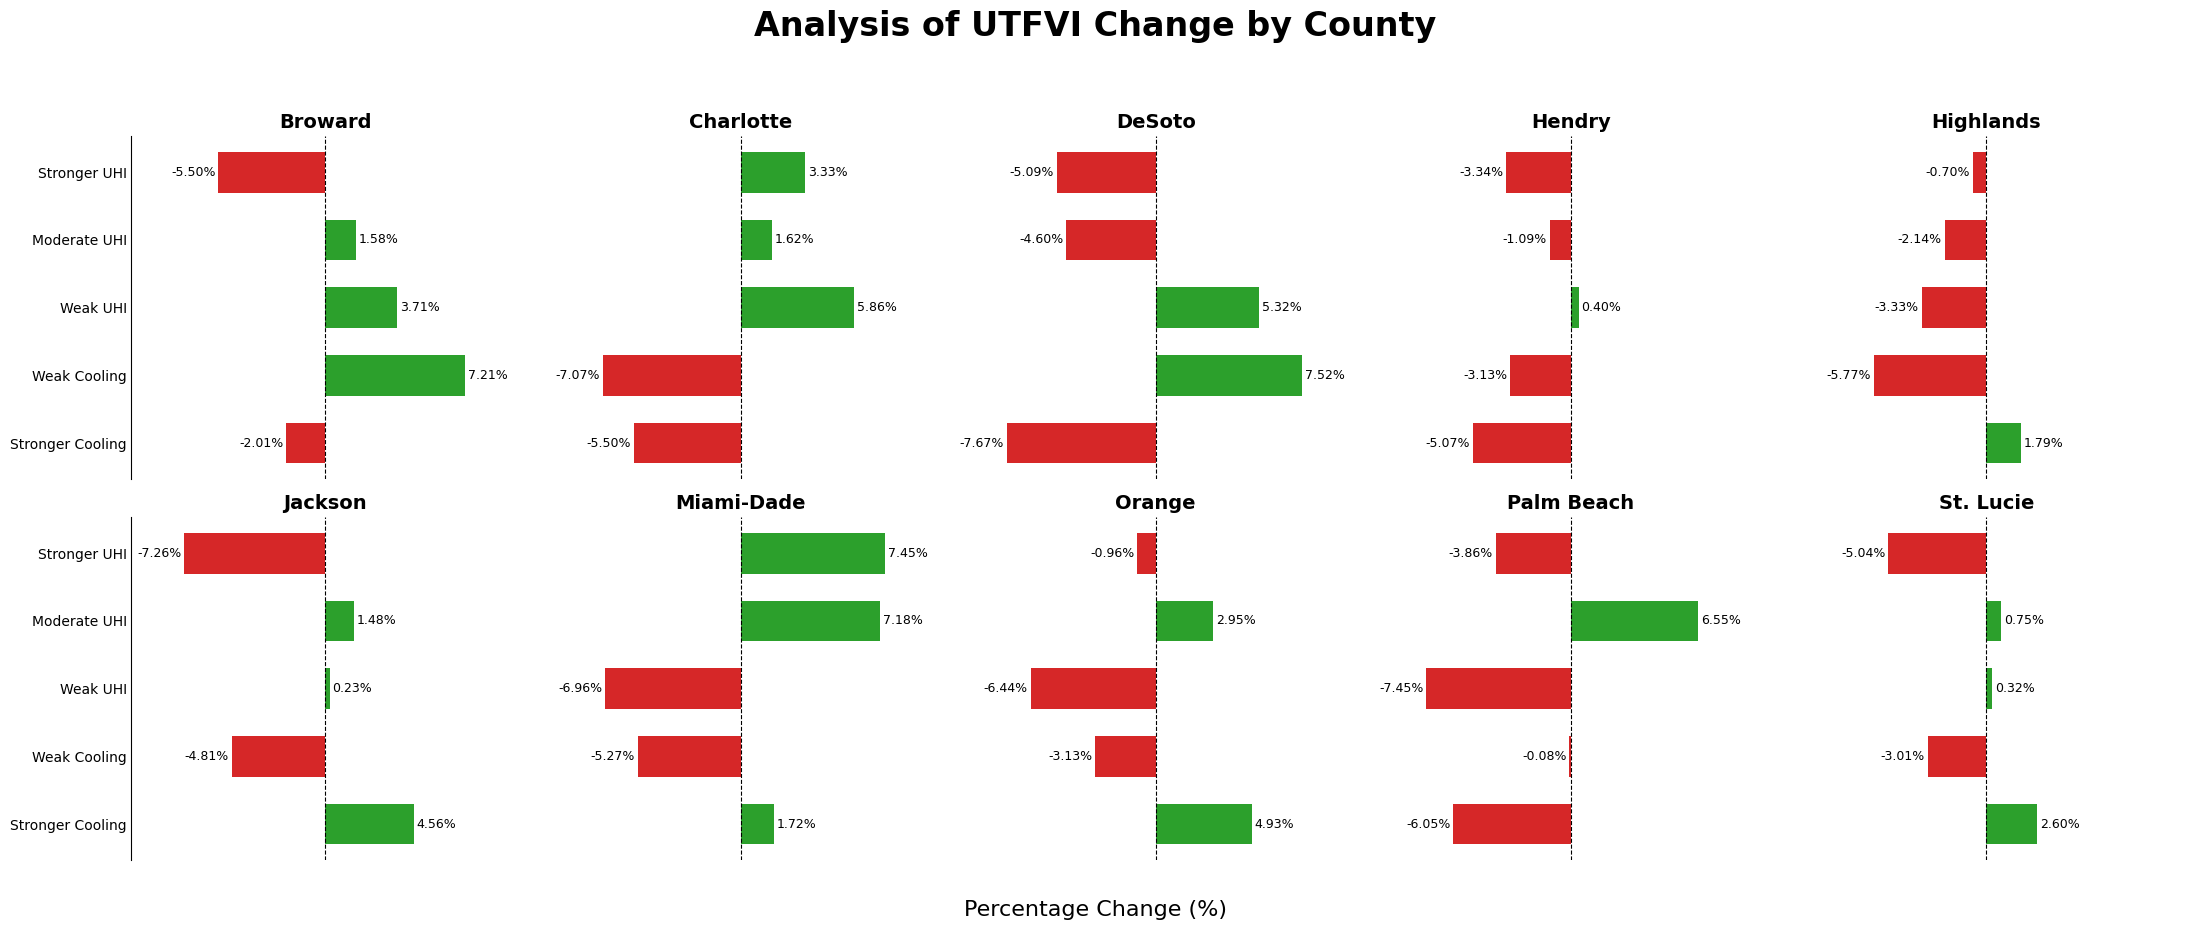

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# --------------------------------------------------------------------------
# 1. (Optional) CREATE DUMMY CSV FILES FOR DEMONSTRATION
#    If you already have your CSV files, you can delete this section.
# --------------------------------------------------------------------------
print("Creating dummy CSV files for demonstration...")

# Define the exact file names and corresponding county names from your image
file_info = {
    'UTFVI_Report_Broward_1985-2024.csv': 'Broward',
    'UTFVI_Report_Charlotte_1985-2024.csv': 'Charlotte',
    'UTFVI_Report_DeSoto_1985-2024.csv': 'DeSoto',
    'UTFVI_Report_Hendry_1985-2024.csv': 'Hendry',
    'UTFVI_Report_Highlands_1985-2024.csv': 'Highlands',
    'UTFVI_Report_Jackson_1985-2024.csv': 'Jackson',
    'UTFVI_Report_Miami-Dade_1985-2024.csv': 'Miami-Dade',
    'UTFVI_Report_Orange_1985-2024.csv': 'Orange',
    'UTFVI_Report_Palm Beach_1985-2024.csv': 'Palm Beach',
    'UTFVI_Report_St. Lucie_1985-2024.csv': 'St. Lucie'
}

categories = [
    'Stronger Cooling', 'Weak Cooling', 'Weak UHI', 'Moderate UHI', 'Stronger UHI'
]

# Seed for reproducible random data
np.random.seed(42)
for filename in file_info.keys():
    # Generate random change data for 5 categories
    change_data = np.random.uniform(-8, 8, size=len(categories))
    df = pd.DataFrame({'Category': categories, 'Change': change_data})
    df.to_csv(filename, index=False)

print("Dummy files created successfully.\n")

# --------------------------------------------------------------------------
# 2. LOAD DATA FROM CSV FILES AND PREPARE FOR PLOTTING
# --------------------------------------------------------------------------
print("Loading data from CSV files...")
county_data = {}
max_abs_value = 0

for filename, county_name in file_info.items():
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        # Ensure the order matches the 'categories' list
        df['Category'] = pd.Categorical(df['Category'], categories=categories, ordered=True)
        df = df.sort_values('Category')
        
        data_values = df['Change'].values
        county_data[county_name] = data_values
        
        # Track the largest value to set a consistent x-axis scale
        current_max = np.max(np.abs(data_values))
        if current_max > max_abs_value:
            max_abs_value = current_max
    else:
        print(f"Warning: File not found - {filename}")

# Add padding to the limit to ensure text labels fit inside the plot.
padded_limit = max_abs_value * 1.30

print("Data loaded. Preparing to plot...")

# --------------------------------------------------------------------------
# 3. CREATE THE VISUALIZATION
# --------------------------------------------------------------------------
# Create a 2x5 grid of subplots, which perfectly fits 10 counties
fig, axes = plt.subplots(2, 5, figsize=(22, 10), sharey=True)
axes_flat = axes.flatten() # Flatten the 2D array of axes for easy iteration.

# Main Loop to Create a Plot for Each County
for i, county_name in enumerate(county_data.keys()):
    ax = axes_flat[i]
    data = county_data[county_name]

    # --- Plotting the Bars ---
    colors = ['#d62728' if val < 0 else '#2ca02c' for val in data] # Red for negative, green for positive
    y_pos = np.arange(len(categories))
    ax.barh(y_pos, data, color=colors, height=0.6)

    # --- Adding Text Labels to Each Bar ---
    for j, val in enumerate(data):
        ha = 'right' if val < 0 else 'left' # Horizontal alignment for text
        x_pos = val - 0.15 if val < 0 else val + 0.15 # Position text just outside the bar
        ax.text(x_pos, y_pos[j], f'{val:.2f}%', va='center', ha=ha, fontsize=9, fontweight='medium')

    # --- Formatting Each Subplot ---
    ax.set_title(county_name, fontsize=14, fontweight='bold')
    ax.set_xlim(-padded_limit, padded_limit) # Apply the global, symmetrical limit
    ax.axvline(0, color='black', linewidth=0.8, linestyle='--') # Add a zero line

    # Clean up spines and ticks
    ax.spines[['top', 'right', 'bottom']].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax.tick_params(axis='y', length=0)

    # Only show y-axis labels on the first column for clarity
    if i % 5 != 0:
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)

# --- Final Figure-Level Adjustments ---
# Set the shared y-axis labels
plt.yticks(y_pos, categories)

fig.suptitle('Analysis of UTFVI Change by County', fontsize=24, fontweight='bold')
fig.supxlabel('Percentage Change (%)', fontsize=16, y=0.07)

# Adjust layout to prevent titles from overlapping
plt.tight_layout(rect=[0, 0.08, 1, 0.94])

plt.show()